# Imports

In [1]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


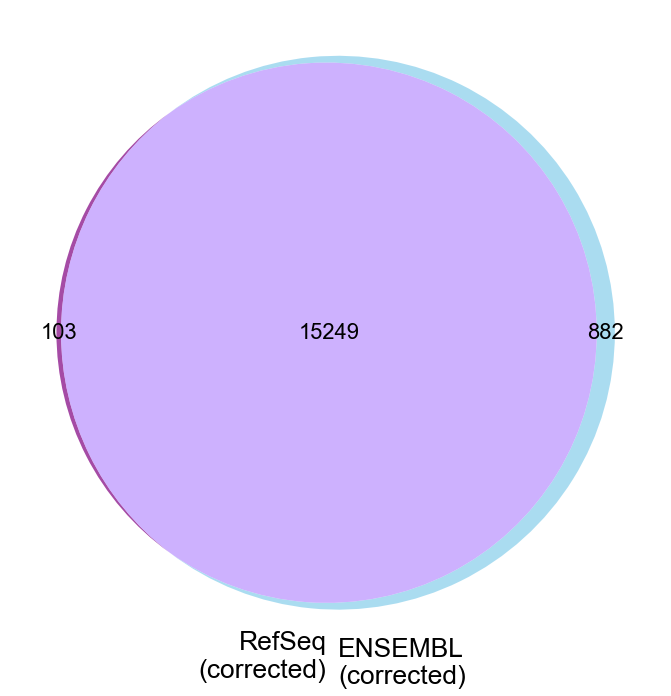

In [79]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size' : 22})
venn2(subsets = (103, 882, 15249, ), set_labels = ('RefSeq\n(corrected)', 'ENSEMBL\n(corrected)'), set_colors=('purple', 'skyblue'), alpha = 0.7)


# RefSeq GRCh38 parsing to retrieve exon-intron boundaries

In [8]:
import pandas as pd
pd.set_option('display.width', 1000)
refseq_grch37_gff = "/gstock/biolo_datasets/variation/benchmark/Databases/RefSeq/GCF_000001405.25_GRCh37.p13_genomic.gff.gz"
refseq_df = pd.read_csv(refseq_grch37_gff, compression='gzip', sep='\t', skiprows=9, names=['NC', 'RefSeq_validation', 'Region_type', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes'])
refseq_df = refseq_df.dropna(subset=['Start', 'End'])
refseq_df['Start'] = refseq_df['Start'].astype(int)
refseq_df['End'] = refseq_df['End'].astype(int)
# refseq_df['Attributes']
refseq_df

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
0,NC_000001.10,RefSeq,region,1,249250621,.,+,.,ID=NC_000001.10:1..249250621;Dbxref=taxon:9606...
1,NC_000001.10,BestRefSeq,pseudogene,11874,14409,.,+,.,"ID=gene-DDX11L1;Dbxref=GeneID:100287102,HGNC:H..."
2,NC_000001.10,BestRefSeq,transcript,11874,14409,.,+,.,ID=rna-NR_046018.2;Parent=gene-DDX11L1;Dbxref=...
3,NC_000001.10,BestRefSeq,exon,11874,12227,.,+,.,ID=exon-NR_046018.2-1;Parent=rna-NR_046018.2;D...
4,NC_000001.10,BestRefSeq,exon,12613,12721,.,+,.,ID=exon-NR_046018.2-2;Parent=rna-NR_046018.2;D...
...,...,...,...,...,...,...,...,...,...
1593531,NC_012920.1,RefSeq,exon,15888,15953,.,+,.,ID=exon-TRNT-1;Parent=rna-TRNT;Dbxref=GeneID:4...
1593532,NC_012920.1,RefSeq,gene,15956,16023,.,-,.,"ID=gene-TRNP;Dbxref=GeneID:4571,HGNC:HGNC:7494..."
1593533,NC_012920.1,RefSeq,tRNA,15956,16023,.,-,.,ID=rna-TRNP;Parent=gene-TRNP;Dbxref=GeneID:457...
1593534,NC_012920.1,RefSeq,exon,15956,16023,.,-,.,ID=exon-TRNP-1;Parent=rna-TRNP;Dbxref=GeneID:4...


In [9]:
refseq_df_chroms = refseq_df.loc[refseq_df['Region_type'] == 'region']
index_list = list(refseq_df_chroms.index)
index_list

chroms = [(i,index_list[j+1]-1) for j,i in enumerate(index_list) if j < (len(index_list)-1)]
# chroms = [i for i,j in enumerate(index_list)]
refseq_df_chroms

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
0,NC_000001.10,RefSeq,region,1,249250621,.,+,.,ID=NC_000001.10:1..249250621;Dbxref=taxon:9606...
134724,NT_113878.1,RefSeq,region,1,106433,.,+,.,ID=NT_113878.1:1..106433;Dbxref=taxon:9606;Nam...
134727,NT_167207.1,RefSeq,region,1,547496,.,+,.,ID=NT_167207.1:1..547496;Dbxref=taxon:9606;Nam...
134796,NC_000002.11,RefSeq,region,1,243199373,.,+,.,ID=NC_000002.11:1..243199373;Dbxref=taxon:9606...
248992,NC_000003.11,RefSeq,region,1,198022430,.,+,.,ID=NC_000003.11:1..198022430;Dbxref=taxon:9606...
...,...,...,...,...,...,...,...,...,...
1574958,NT_167248.1,RefSeq,region,1,4611984,.,+,.,ID=NT_167248.1:1..4611984;Dbxref=taxon:9606;Na...
1583985,NT_167249.1,RefSeq,region,1,4928567,.,+,.,ID=NT_167249.1:1..4928567;Dbxref=taxon:9606;Na...
1592059,NT_167250.1,RefSeq,region,1,590426,.,+,.,ID=NT_167250.1:1..590426;Dbxref=taxon:9606;Nam...
1592300,NT_167251.1,RefSeq,region,1,1680828,.,+,.,ID=NT_167251.1:1..1680828;Dbxref=taxon:9606;Na...


In [10]:
pd.options.display.max_colwidth = 200
refseq_df_pc_genes = refseq_df.loc[(refseq_df['Attributes'].str.contains('gene_biotype=protein_coding')) & (refseq_df['NC'].str.contains('NC_'))]
refseq_df_pc_genes

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
38,NC_000001.10,BestRefSeq,gene,69091,70008,.,+,.,"ID=gene-OR4F5;Dbxref=GeneID:79501,HGNC:HGNC:14825;Name=OR4F5;description=olfactory receptor family 4 subfamily F member 5;gbkey=Gene;gene=OR4F5;gene_biotype=protein_coding"
70,NC_000001.10,BestRefSeq,gene,367659,368597,.,+,.,"ID=gene-OR4F29;Dbxref=GeneID:729759,HGNC:HGNC:31275;Name=OR4F29;description=olfactory receptor family 4 subfamily F member 29;gbkey=Gene;gene=OR4F29;gene_biotype=protein_coding;gene_synonym=OR7-21"
97,NC_000001.10,BestRefSeq,gene,621096,622034,.,-,.,"ID=gene-OR4F16;Dbxref=GeneID:81399,HGNC:HGNC:15079;Name=OR4F16;description=olfactory receptor family 4 subfamily F member 16;gbkey=Gene;gene=OR4F16;gene_biotype=protein_coding;gene_synonym=OR1-1,O..."
182,NC_000001.10,BestRefSeq,gene,861111,879954,.,+,.,"ID=gene-SAMD11;Dbxref=GeneID:148398,HGNC:HGNC:28706,MIM:616765;Name=SAMD11;description=sterile alpha motif domain containing 11;gbkey=Gene;gene=SAMD11;gene_biotype=protein_coding;gene_synonym=MRS"
211,NC_000001.10,BestRefSeq,gene,879583,894636,.,-,.,"ID=gene-NOC2L;Dbxref=GeneID:26155,HGNC:HGNC:24517,MIM:610770;Name=NOC2L;description=NOC2 like nucleolar associated transcriptional repressor;gbkey=Gene;gene=NOC2L;gene_biotype=protein_coding;gene_..."
...,...,...,...,...,...,...,...,...,...
1593507,NC_012920.1,RefSeq,gene,10470,10766,.,+,.,"ID=gene-ND4L;Dbxref=GeneID:4539,HGNC:HGNC:7460,MIM:516004;Name=ND4L;gbkey=Gene;gene=ND4L;gene_biotype=protein_coding;gene_synonym=MTND4L"
1593509,NC_012920.1,RefSeq,gene,10760,12137,.,+,.,"ID=gene-ND4;Dbxref=GeneID:4538,HGNC:HGNC:7459,MIM:516003;Name=ND4;gbkey=Gene;gene=ND4;gene_biotype=protein_coding;gene_synonym=MTND4"
1593520,NC_012920.1,RefSeq,gene,12337,14148,.,+,.,"ID=gene-ND5;Dbxref=GeneID:4540,HGNC:HGNC:7461,MIM:516005;Name=ND5;gbkey=Gene;gene=ND5;gene_biotype=protein_coding;gene_synonym=MTND5"
1593522,NC_012920.1,RefSeq,gene,14149,14673,.,-,.,"ID=gene-ND6;Dbxref=GeneID:4541,HGNC:HGNC:7462,MIM:516006;Name=ND6;gbkey=Gene;gene=ND6;gene_biotype=protein_coding;gene_synonym=MTND6"


In [ ]:
refseq_df_pc_genes.loc[refseq_df_pc_genes['Attributes'].str.contains('LOC105378947')]

In [11]:
pd.options.display.max_colwidth = 200
refseq_df_mrna = refseq_df.loc[(refseq_df['Attributes'].str.contains('NM_'))  & (refseq_df['Region_type'] == 'mRNA') & (refseq_df['NC'].str.contains('NC_'))]
refseq_df_mrna

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
39,NC_000001.10,BestRefSeq,mRNA,69091,70008,.,+,.,"ID=rna-NM_001005484.1;Parent=gene-OR4F5;Dbxref=GeneID:79501,Genbank:NM_001005484.1,HGNC:HGNC:14825;Name=NM_001005484.1;gbkey=mRNA;gene=OR4F5;product=olfactory receptor family 4 subfamily F member ..."
71,NC_000001.10,BestRefSeq,mRNA,367659,368597,.,+,.,"ID=rna-NM_001005221.2;Parent=gene-OR4F29;Dbxref=GeneID:729759,Genbank:NM_001005221.2,HGNC:HGNC:31275;Name=NM_001005221.2;gbkey=mRNA;gene=OR4F29;product=olfactory receptor family 4 subfamily F memb..."
98,NC_000001.10,BestRefSeq,mRNA,621096,622034,.,-,.,"ID=rna-NM_001005277.1;Parent=gene-OR4F16;Dbxref=GeneID:81399,Genbank:NM_001005277.1,HGNC:HGNC:15079;Name=NM_001005277.1;gbkey=mRNA;gene=OR4F16;product=olfactory receptor family 4 subfamily F membe..."
183,NC_000001.10,BestRefSeq,mRNA,861111,879954,.,+,.,"ID=rna-NM_152486.3;Parent=gene-SAMD11;Dbxref=GeneID:148398,Genbank:NM_152486.3,HGNC:HGNC:28706,MIM:616765;Name=NM_152486.3;Note=The RefSeq transcript has 1 substitution compared to this genomic se..."
212,NC_000001.10,BestRefSeq,mRNA,879583,894636,.,-,.,"ID=rna-NM_015658.4;Parent=gene-NOC2L;Dbxref=GeneID:26155,Genbank:NM_015658.4,HGNC:HGNC:24517,MIM:610770;Name=NM_015658.4;gbkey=mRNA;gene=NOC2L;product=NOC2 like nucleolar associated transcriptiona..."
...,...,...,...,...,...,...,...,...,...
1455342,NC_000024.9,BestRefSeq,mRNA,59214014,59276439,.,+,.,"ID=rna-NM_005638.6-2;Parent=gene-VAMP7-2;Dbxref=GeneID:6845,Genbank:NM_005638.6,HGNC:HGNC:11486,MIM:300053;Name=NM_005638.6;gbkey=mRNA;gene=VAMP7;product=vesicle associated membrane protein 7%2C t..."
1455358,NC_000024.9,BestRefSeq,mRNA,59214014,59276439,.,+,.,"ID=rna-NM_001185183.2-2;Parent=gene-VAMP7-2;Dbxref=GeneID:6845,Genbank:NM_001185183.2,HGNC:HGNC:11486,MIM:300053;Name=NM_001185183.2;gbkey=mRNA;gene=VAMP7;product=vesicle associated membrane prote..."
1455372,NC_000024.9,BestRefSeq,mRNA,59214014,59276439,.,+,.,"ID=rna-NM_001145149.3-2;Parent=gene-VAMP7-2;Dbxref=GeneID:6845,Genbank:NM_001145149.3,HGNC:HGNC:11486,MIM:300053;Name=NM_001145149.3;gbkey=mRNA;gene=VAMP7;product=vesicle associated membrane prote..."
1455390,NC_000024.9,BestRefSeq,mRNA,59330367,59343488,.,+,.,"ID=rna-NM_176786.2-2;Parent=gene-IL9R-2;Dbxref=GeneID:3581,Genbank:NM_176786.2,HGNC:HGNC:6030,MIM:300007;Name=NM_176786.2;gbkey=mRNA;gene=IL9R;product=interleukin 9 receptor%2C transcript variant ..."


In [12]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 20
refseq_df_exons = refseq_df.loc[(refseq_df['Attributes'].str.contains('exon-NM'))  & (refseq_df['Region_type'] == 'exon')  & (refseq_df['NC'].str.contains('NC_'))]
refseq_df_exons

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
40,NC_000001.10,BestRefSeq,exon,69091,70008,.,+,.,"ID=exon-NM_001005484.1-1;Parent=rna-NM_001005484.1;Dbxref=GeneID:79501,Genbank:NM_001005484.1,HGNC:HGNC:14825;gbkey=mRNA;gene=OR4F5;product=olfactory receptor family 4 subfamily F member 5;tag=Ref..."
72,NC_000001.10,BestRefSeq,exon,367659,368597,.,+,.,"ID=exon-NM_001005221.2-1;Parent=rna-NM_001005221.2;Dbxref=GeneID:729759,Genbank:NM_001005221.2,HGNC:HGNC:31275;gbkey=mRNA;gene=OR4F29;product=olfactory receptor family 4 subfamily F member 29;tag=..."
99,NC_000001.10,BestRefSeq,exon,621096,622034,.,-,.,"ID=exon-NM_001005277.1-1;Parent=rna-NM_001005277.1;Dbxref=GeneID:81399,Genbank:NM_001005277.1,HGNC:HGNC:15079;gbkey=mRNA;gene=OR4F16;product=olfactory receptor family 4 subfamily F member 16;tag=R..."
184,NC_000001.10,BestRefSeq,exon,861111,861180,.,+,.,"ID=exon-NM_152486.3-1;Parent=rna-NM_152486.3;Dbxref=GeneID:148398,Genbank:NM_152486.3,HGNC:HGNC:28706,MIM:616765;Note=The RefSeq transcript has 1 substitution compared to this genomic sequence;exc..."
185,NC_000001.10,BestRefSeq,exon,861302,861393,.,+,.,"ID=exon-NM_152486.3-2;Parent=rna-NM_152486.3;Dbxref=GeneID:148398,Genbank:NM_152486.3,HGNC:HGNC:28706,MIM:616765;Note=The RefSeq transcript has 1 substitution compared to this genomic sequence;exc..."
...,...,...,...,...,...,...,...,...,...
1455414,NC_000024.9,BestRefSeq,exon,59337091,59337236,.,+,.,"ID=exon-NM_002186.3-2-5;Parent=rna-NM_002186.3-2;Dbxref=GeneID:3581,Genbank:NM_002186.3,HGNC:HGNC:6030,MIM:300007;gbkey=mRNA;gene=IL9R;product=interleukin 9 receptor%2C transcript variant 1;transc..."
1455415,NC_000024.9,BestRefSeq,exon,59337949,59338150,.,+,.,"ID=exon-NM_002186.3-2-6;Parent=rna-NM_002186.3-2;Dbxref=GeneID:3581,Genbank:NM_002186.3,HGNC:HGNC:6030,MIM:300007;gbkey=mRNA;gene=IL9R;product=interleukin 9 receptor%2C transcript variant 1;transc..."
1455416,NC_000024.9,BestRefSeq,exon,59338754,59338859,.,+,.,"ID=exon-NM_002186.3-2-7;Parent=rna-NM_002186.3-2;Dbxref=GeneID:3581,Genbank:NM_002186.3,HGNC:HGNC:6030,MIM:300007;gbkey=mRNA;gene=IL9R;product=interleukin 9 receptor%2C transcript variant 1;transc..."
1455417,NC_000024.9,BestRefSeq,exon,59340194,59340278,.,+,.,"ID=exon-NM_002186.3-2-8;Parent=rna-NM_002186.3-2;Dbxref=GeneID:3581,Genbank:NM_002186.3,HGNC:HGNC:6030,MIM:300007;gbkey=mRNA;gene=IL9R;product=interleukin 9 receptor%2C transcript variant 1;transc..."


In [13]:
pd.options.display.max_colwidth = 200
refseq_df_cds = refseq_df.loc[(refseq_df['Attributes'].str.contains('NP_'))  & (refseq_df['Region_type'] == 'CDS')  & (refseq_df['NC'].str.contains('NC_'))]
refseq_df_cds

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes
41,NC_000001.10,BestRefSeq,CDS,69091,70008,.,+,0,"ID=cds-NP_001005484.1;Parent=rna-NM_001005484.1;Dbxref=CCDS:CCDS30547.1,GeneID:79501,Genbank:NP_001005484.1,HGNC:HGNC:14825;Name=NP_001005484.1;gbkey=CDS;gene=OR4F5;product=olfactory receptor 4F5;..."
73,NC_000001.10,BestRefSeq,CDS,367659,368597,.,+,0,"ID=cds-NP_001005221.2;Parent=rna-NM_001005221.2;Dbxref=CCDS:CCDS72675.1,GeneID:729759,Genbank:NP_001005221.2,HGNC:HGNC:31275;Name=NP_001005221.2;gbkey=CDS;gene=OR4F29;product=olfactory receptor 4F..."
100,NC_000001.10,BestRefSeq,CDS,621096,622034,.,-,0,"ID=cds-NP_001005277.1;Parent=rna-NM_001005277.1;Dbxref=CCDS:CCDS41221.1,GeneID:81399,Genbank:NP_001005277.1,HGNC:HGNC:15079;Name=NP_001005277.1;gbkey=CDS;gene=OR4F16;product=olfactory receptor 4F3..."
198,NC_000001.10,BestRefSeq,CDS,861322,861393,.,+,0,"ID=cds-NP_689699.2;Parent=rna-NM_152486.3;Dbxref=CCDS:CCDS2.2,GeneID:148398,Genbank:NP_689699.2,HGNC:HGNC:28706,MIM:616765;Name=NP_689699.2;Note=The RefSeq protein has 1 substitution compared to t..."
199,NC_000001.10,BestRefSeq,CDS,865535,865716,.,+,0,"ID=cds-NP_689699.2;Parent=rna-NM_152486.3;Dbxref=CCDS:CCDS2.2,GeneID:148398,Genbank:NP_689699.2,HGNC:HGNC:28706,MIM:616765;Name=NP_689699.2;Note=The RefSeq protein has 1 substitution compared to t..."
...,...,...,...,...,...,...,...,...,...
1455423,NC_000024.9,BestRefSeq,CDS,59337091,59337236,.,+,2,"ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;Dbxref=CCDS:CCDS14771.4,GeneID:3581,Genbank:NP_002177.2,HGNC:HGNC:6030,MIM:300007;Name=NP_002177.2;Note=isoform 1 precursor is encoded by transcript v..."
1455424,NC_000024.9,BestRefSeq,CDS,59337949,59338150,.,+,0,"ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;Dbxref=CCDS:CCDS14771.4,GeneID:3581,Genbank:NP_002177.2,HGNC:HGNC:6030,MIM:300007;Name=NP_002177.2;Note=isoform 1 precursor is encoded by transcript v..."
1455425,NC_000024.9,BestRefSeq,CDS,59338754,59338859,.,+,2,"ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;Dbxref=CCDS:CCDS14771.4,GeneID:3581,Genbank:NP_002177.2,HGNC:HGNC:6030,MIM:300007;Name=NP_002177.2;Note=isoform 1 precursor is encoded by transcript v..."
1455426,NC_000024.9,BestRefSeq,CDS,59340194,59340278,.,+,1,"ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;Dbxref=CCDS:CCDS14771.4,GeneID:3581,Genbank:NP_002177.2,HGNC:HGNC:6030,MIM:300007;Name=NP_002177.2;Note=isoform 1 precursor is encoded by transcript v..."


In [14]:
from tqdm import tqdm
l = list()


# for j, index in tqdm(enumerate(list(refseq_df_pc_genes.index))):

def test_mp(t, l):
    j, index = t[0], t[1]
#     if j == 10:
#         break

    if j < len(list(refseq_df_pc_genes.index)) - 1 :
        start_index, stop_index = index, list(refseq_df_pc_genes.index)[j+1]

        current_gene = [e.replace('Name=', '') for e in refseq_df_pc_genes.loc[start_index]['Attributes'].split(';') if 'Name' in e][0]
        for e, cds in enumerate(list(refseq_df_exons.index)):
            if cds > start_index and cds < stop_index:

                current_gene_cds = [e.replace('gene=', '') for e in refseq_df_exons.loc[cds]['Attributes'].split(';') if 'gene' in e][0]
                parent_mrna = [e.replace('Parent=rna-', '') for e in refseq_df_exons.loc[cds]['Attributes'].split(';') if 'Parent' in e][0].split('.')[0]
                mrna_index = refseq_df_mrna.loc[refseq_df_mrna['Attributes'].str.contains(parent_mrna)].index[0]
                
                

#                 print(j, start_index, stop_index, cds, current_gene, current_gene_cds)

                if current_gene == current_gene_cds:
                    l.append(
                        {
                            'Gene' : current_gene,
                            'Gene_start' : refseq_df_pc_genes.loc[start_index]['Start'],
                            'Gene_stop' : refseq_df_pc_genes.loc[start_index]['End'],
                            'Exon_start' : refseq_df_exons.loc[cds]['Start'],
                            'Exon_stop' : refseq_df_exons.loc[cds]['End'],
                            'mRNA' : parent_mrna,
                            'mRNA_start' : refseq_df_mrna.loc[mrna_index]['Start'],
                            'mRNA_stop' : refseq_df_mrna.loc[mrna_index]['End'],
                            'Exon_type' : 'Exon',
                        }
                    )

m = multiprocessing.Manager()
l = m.list()
parmap.starmap(test_mp, list(zip(enumerate(list(refseq_df_pc_genes.index)))), l, pm_pbar=True)
            
            
pd.options.display.max_rows = 20 
df = pd.DataFrame(list(l)).sort_values(by=['Gene', 'Exon_start', 'Exon_stop']).drop_duplicates()
df['Length'] = df['Exon_stop'] - df['Exon_start']
df = df.sort_values(by=['Gene', 'Exon_start', 'Exon_stop', 'Length'], ascending=[True, True, True, False])
# df = df.drop_duplicates(subset=['Gene', 'Exon_start'], keep='last').drop_duplicates(subset=['Gene', 'Exon_stop'], keep='first')
df.to_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_37_tmp_exons_part.parquet')
df


19380it [19:27, 16.60it/s]                           


,Gene,Gene_start,Gene_stop,Exon_start,Exon_stop,mRNA,mRNA_start,mRNA_stop,Exon_type,Length
574886,A1BG,58856549,58864858,58856549,58858395,NM_130786,58856549,58864858,Exon,1846
574853,A1BG,58856549,58864858,58858719,58859006,NM_130786,58856549,58864858,Exon,287
574825,A1BG,58856549,58864858,58861736,58862017,NM_130786,58856549,58864858,Exon,281
574797,A1BG,58856549,58864858,58862757,58863053,NM_130786,58856549,58864858,Exon,296
574756,A1BG,58856549,58864858,58863649,58863921,NM_130786,58856549,58864858,Exon,272
...,...,...,...,...,...,...,...,...,...,...
64477,ZZZ3,78028101,78149112,78107069,78107131,NM_015534,78028101,78148343,Exon,62
63534,ZZZ3,78028101,78149112,78107207,78107340,NM_001308237,78028101,78149112,Exon,133
64412,ZZZ3,78028101,78149112,78107207,78107340,NM_015534,78028101,78148343,Exon,133
64314,ZZZ3,78028101,78149112,78148270,78148343,NM_015534,78028101,78148343,Exon,73


In [15]:
from tqdm import tqdm
l = list()


# for j, index in tqdm(enumerate(list(refseq_df_pc_genes.index))):

def test_mp(t, l):
    j, index = t[0], t[1]
#     if j == 10:
#         break

    if j < len(list(refseq_df_pc_genes.index)) - 1 :
        start_index, stop_index = index, list(refseq_df_pc_genes.index)[j+1]

        current_gene = [e.replace('Name=', '') for e in refseq_df_pc_genes.loc[start_index]['Attributes'].split(';') if 'Name' in e][0]
        for cds in list(refseq_df_cds.index):
            if cds > start_index and cds < stop_index:

                current_gene_cds = [e.replace('gene=', '') for e in refseq_df_cds.loc[cds]['Attributes'].split(';') if 'gene' in e][0]
                parent_mrna = [e.replace('Parent=rna-', '') for e in refseq_df_cds.loc[cds]['Attributes'].split(';') if 'Parent' in e][0].split('.')[0]
                mrna_index = refseq_df_mrna.loc[refseq_df_mrna['Attributes'].str.contains(parent_mrna)].index[0]
                
                

#                 print(j, start_index, stop_index, cds, current_gene, current_gene_cds)

                if current_gene == current_gene_cds:
                    l.append(
                        {
                            'Gene' : current_gene,
                            'Gene_start' : refseq_df_pc_genes.loc[start_index]['Start'],
                            'Gene_stop' : refseq_df_pc_genes.loc[start_index]['End'],
                            'Exon_start' : refseq_df_cds.loc[cds]['Start'],
                            'Exon_stop' : refseq_df_cds.loc[cds]['End'],
                            'mRNA' : parent_mrna,
                            'mRNA_start' : refseq_df_mrna.loc[mrna_index]['Start'],
                            'mRNA_stop' : refseq_df_mrna.loc[mrna_index]['End'],
                            'Exon_type' : 'CDS',
                        }
                    )

m = multiprocessing.Manager()
l = m.list()
parmap.starmap(test_mp, list(zip(enumerate(list(refseq_df_pc_genes.index)))), l, pm_pbar=True)
            
            
pd.options.display.max_rows = 20
df = pd.DataFrame(list(l)).sort_values(by=['Gene', 'Exon_start', 'Exon_stop']).drop_duplicates()
df['Length'] = df['Exon_stop'] - df['Exon_start']
df = df.sort_values(by=['Gene', 'Exon_start', 'Exon_stop', 'Length'], ascending=[True, True, True, False])
# df = df.drop_duplicates(subset=['Gene', 'Exon_start'], keep='last').drop_duplicates(subset=['Gene', 'Exon_stop'], keep='first')
df.to_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_37_tmp_cds_part.parquet')
df


19380it [17:05, 18.90it/s]                           


,Gene,Gene_start,Gene_stop,Exon_start,Exon_stop,mRNA,mRNA_start,mRNA_stop,Exon_type,Length
501720,A1BG,58856549,58864858,58858388,58858395,NM_130786,58856549,58864858,CDS,7
501677,A1BG,58856549,58864858,58858719,58859006,NM_130786,58856549,58864858,CDS,287
501639,A1BG,58856549,58864858,58861736,58862017,NM_130786,58856549,58864858,CDS,281
501564,A1BG,58856549,58864858,58862757,58863053,NM_130786,58856549,58864858,CDS,296
501489,A1BG,58856549,58864858,58863649,58863921,NM_130786,58856549,58864858,CDS,272
...,...,...,...,...,...,...,...,...,...,...
58121,ZZZ3,78028101,78149112,78047664,78047811,NM_015534,78028101,78148343,CDS,147
57489,ZZZ3,78028101,78149112,78050202,78050340,NM_001308237,78028101,78149112,CDS,138
58046,ZZZ3,78028101,78149112,78050202,78050340,NM_015534,78028101,78148343,CDS,138
57982,ZZZ3,78028101,78149112,78097535,78099039,NM_015534,78028101,78148343,CDS,1504


In [16]:
concat_df_exons_cds = pd.concat(
    [
        pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_37_tmp_exons_part.parquet'),
        pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_37_tmp_cds_part.parquet')
    ]    
).sort_values(by=['Gene', 'Exon_start', 'Exon_stop'])
concat_df_exons_cds

,Gene,Gene_start,Gene_stop,Exon_start,Exon_stop,mRNA,mRNA_start,mRNA_stop,Exon_type,Length
574886,A1BG,58856549,58864858,58856549,58858395,NM_130786,58856549,58864858,Exon,1846
501720,A1BG,58856549,58864858,58858388,58858395,NM_130786,58856549,58864858,CDS,7
574853,A1BG,58856549,58864858,58858719,58859006,NM_130786,58856549,58864858,Exon,287
501677,A1BG,58856549,58864858,58858719,58859006,NM_130786,58856549,58864858,CDS,287
574825,A1BG,58856549,58864858,58861736,58862017,NM_130786,58856549,58864858,Exon,281
...,...,...,...,...,...,...,...,...,...,...
64477,ZZZ3,78028101,78149112,78107069,78107131,NM_015534,78028101,78148343,Exon,62
63534,ZZZ3,78028101,78149112,78107207,78107340,NM_001308237,78028101,78149112,Exon,133
64412,ZZZ3,78028101,78149112,78107207,78107340,NM_015534,78028101,78148343,Exon,133
64314,ZZZ3,78028101,78149112,78148270,78148343,NM_015534,78028101,78148343,Exon,73


In [ ]:
concat_df_exons_cds.to_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_tmp_exons_cds.parquet')

In [ ]:
concat_df_exons_cds = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_tmp_exons_cds.parquet')

In [ ]:
concat_df_exons_cds

In [ ]:
df.to_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_tmp.parquet')

In [ ]:
df = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/refseq_tmp.parquet')
df['Exon_start'] = df['Exon_start'].astype(str)
df['Exon_stop'] = df['Exon_stop'].astype(str)

In [ ]:
df.sort_values(by=['Gene', 'Gene_start', 'Exon_start'])

In [ ]:
df.groupby(['Gene', 'mRNA'])['Exon_start'].apply(lambda r: ','.join(r))

In [ ]:
df.groupby(['Gene', 'mRNA'])['Exon_stop'].apply(lambda r: ','.join(r))

In [ ]:
concat_exons.reset_index().mRNA.nunique()

In [ ]:
concat_exons = pd.concat([df.groupby(['Gene', 'mRNA'])['Exon_start'].apply(lambda r: ','.join(r)), df.groupby(['Gene', 'mRNA'])['Exon_stop'].apply(lambda r: ','.join(r))], axis=1)
concat_exons['Exon_list'] = concat_exons[['Exon_start', 'Exon_stop']].apply(lambda r: [start + '_' + stop for start, stop in zip(r['Exon_start'].split(','), r['Exon_stop'].split(','))], axis=1)
concat_exons 



In [ ]:
concat_exons.reset_index().groupby('Gene')['mRNA'].apply(list)


In [ ]:
concat_exons.reset_index().groupby('Gene')['Exon_list'].apply(list)

In [ ]:
concat_exons_gene_level = pd.concat(
    [
        concat_exons.reset_index().groupby('Gene')['mRNA'].apply(list),
        concat_exons.reset_index().groupby('Gene')['Exon_list'].apply(list)
    ],
    axis=1
)
concat_exons_gene_level = concat_exons_gene_level.reset_index()
concat_exons_gene_level

In [ ]:
concat_exons_gene_level.head()

In [ ]:
concat_exons_gene_level

In [ ]:
concat_exons_gene_level = pd.concat(
    [
        concat_.reset_index().groupby('Gene')['mRNA'].apply(list),
        concat_exons.reset_index().groupby('Gene')['Exon_list'].apply(list)
    ],
    axis=1
)
concat_exons_gene_level = concat_exons_gene_level.reset_index()
concat_exons_gene_level

In [19]:
concat_df_exons_cds['Range'] = concat_df_exons_cds['Exon_start'].astype(str) + '_' + concat_df_exons_cds['Exon_stop'].astype(str) 

In [17]:
mrna_count = pd.DataFrame(concat_df_exons_cds.groupby('Gene')['mRNA'].nunique())
mrna_count = mrna_count.loc[mrna_count['mRNA'] > 1]
mrna_count

,mRNA
Gene,
A1CF,8
A2M,4
A2ML1,2
A4GALT,2
AAAS,2
...,...
ZWINT,3
ZXDC,2
ZYG11A,2


In [ ]:
concat_df_exons_cds.loc[(concat_df_exons_cds['Gene'] == 'A1CF') & (concat_df_exons_cds['Exon_type'] == 'CDS')]

In [20]:
tmp_df = concat_df_exons_cds.loc[(concat_df_exons_cds['Gene'].isin(mrna_count.index.tolist())) & (concat_df_exons_cds['Exon_type'] == 'CDS')]
cds_join = pd.DataFrame(tmp_df.groupby(['Gene', 'mRNA'])['Range'].apply(",".join))
cds_join.columns = ['CDS_ranges']
cds_join

CDS_ranges
Gene mRNA                                                                                                                                                                                                               
A1CF NM_001198818  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
     NM_001198819  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_52610547
     NM_001198820  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_52610547
     NM_001370130  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
     NM_001370131  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
...                                                                                                                                                                                                                  ...
ZYX  NM_001010972                    143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775
     NM_001362783                                        143078665_143078872,143079341_143079540,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775
     NM_003461                       143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775
ZZZ3 NM_001308237  78031325_78031469,78031766_78031866,78034017_78034151,78041753_78041905,78044459_78044554,78045212_78045313,78046683_78046754,78047461_78047576,78047664_78047811,78050202_78050340,78105134_78105156
     NM_015534     78031325_78031469,78031766_78031866,78034017_78034151,78041753_78041905,78044459_78044554,78045212_78045313,78046683_78046754,78047461_78047576,78047664_78047811,78050202_78050340,78097535_78099039

[45497 rows x 1 columns]

In [21]:
tmp_df = concat_df_exons_cds.loc[(concat_df_exons_cds['Gene'].isin(mrna_count.index.tolist())) & (concat_df_exons_cds['Exon_type'] == 'Exon')]
exon_join = pd.DataFrame(tmp_df.groupby(['Gene', 'mRNA'])['Range'].apply(",".join))
exon_join.columns = ['Exons_ranges']
exon_join

Exons_ranges
Gene mRNA                                                                                                                                                                                                                 
A1CF NM_001198818  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...
     NM_001198819  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_5261056...
     NM_001198820  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_5261056...
     NM_001370130  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...
     NM_001370131  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...
...                                                                                                                                                                                                                    ...
ZYX  NM_001010972  143078438_143078502,143078653_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143088204
     NM_001362783                      143078438_143078502,143078650_143078872,143079341_143079540,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143088204
     NM_003461     143078438_143078502,143078650_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143088204
ZZZ3 NM_001308237  78028101_78031469,78031766_78031866,78034017_78034151,78041753_78041905,78044459_78044554,78045212_78045313,78046683_78046754,78047461_78047576,78047664_78047811,78050202_78050340,78105134_7810528...
     NM_015534     78028101_78031469,78031766_78031866,78034017_78034151,78041753_78041905,78044459_78044554,78045212_78045313,78046683_78046754,78047461_78047576,78047664_78047811,78050202_78050340,78097535_7809909...

[45497 rows x 1 columns]

In [22]:
concat_cds_exon_join = pd.concat([exon_join, cds_join], axis=1)
concat_cds_exon_join

Exons_ranges                                                                                                                                                                                             CDS_ranges
Gene mRNA                                                                                                                                                                                                                                                                                                                                                                                                                        
A1CF NM_001198818  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
     NM_001198819  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_5261056...  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_52610547
     NM_001198820  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_5261056...  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52610425_52610547
     NM_001370130  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
     NM_001370131  52559169_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_5261974...  52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573822,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_52619700
...                                                                                                                                                                                                                    ...                                                                                                                                                                                                    ...
ZYX  NM_001010972  143078438_143078502,143078653_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143088204                    143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775
     NM_001362783                      143078438_143078502,143078650_143078872,143079341_143079540,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143088204                                        143078665_143078872,143079341_143079540,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775
     NM_003461     1430784

In [25]:
merge_with_strand = pd.merge(biomart_raw[['RefSeq mRNA ID', 'Strand']].dropna(), concat_cds_exon_join.reset_index(), left_on='RefSeq mRNA ID', right_on='mRNA').drop_duplicates()
merge_with_strand

,RefSeq mRNA ID,Strand,Gene,mRNA,Exons_ranges,CDS_ranges
0,NM_001318854,1,OPRL1,NM_001318854,"62724041_62724291,62729155_62729510,62729629_62731996","62724074_62724291,62729155_62729510,62729629_62730152"
2,NM_001318855,1,OPRL1,NM_001318855,"62724041_62724334,62729155_62729510,62729629_62731996","62724189_62724334,62729155_62729510,62729629_62730152"
4,NM_001104925,1,PCMTD2,NM_001104925,"62887048_62887223,62891295_62891625,62895782_62895884,62896611_62896782,62899321_62899363,62904574_62907579","62891319_62891625,62895782_62895884,62896611_62896782,62899321_62899363,62904574_62904953"
6,NM_018257,1,PCMTD2,NM_018257,"62887101_62887223,62891295_62891625,62895782_62895884,62896611_62896782,62899240_62899363,62904574_62907579","62891319_62891625,62895782_62895884,62896611_62896782,62899240_62899363,62904574_62904953"
8,NM_023015,1,INTS3,NM_023015,"153700526_153701260,153713127_153713210,153713761_153713844,153719433_153719546,153719755_153719839,153721165_153721231,153723571_153723715,153724755_153724884,153727118_153727215,153730048_153730...","153701111_153701260,153713127_153713210,153713761_153713844,153719433_153719546,153719755_153719839,153721165_153721231,153723571_153723715,153724755_153724884,153727118_153727215,153730048_153730..."
...,...,...,...,...,...,...
49193,NM_001193328,-1,ZNF692,NM_001193328,"249144207_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150713_249150761,249151433_249151696,249152027_249152058,249152330_249152...","249144409_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150713_249150761,249151433_249151696,249152027_249152058,249152330_249152508"
49194,NM_001350073,-1,ZNF692,NM_001350073,"249144207_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150487_249150621,249150713_249150761,249151433_249151696,249151938_249152...","249144409_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150487_249150533"
49195,NM_001136036,-1,ZNF692,NM_001136036,"249144207_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150487_249150621,249150713_249150761,249151433_249151696,249152027_249152...","249144409_249144715,249144881_249144980,249148136_249148250,249149579_249149657,249149757_249149834,249149924_249150145,249150487_249150621,249150713_249150761,249151433_249151696,249152027_249152..."
49196,NM_001017434,1,PGBD2,NM_001017434,"249200442_249200541,249208015_249208078,249211478_249213345",249211537_249212562


In [ ]:
cds_join

In [26]:
test = pd.DataFrame(cds_join.groupby('Gene')['CDS_ranges'].apply(lambda r: list(r))).reset_index()
test

,Gene,CDS_ranges
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197..."
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923..."
2,A2ML1,"[8997768_8997770,8998038_8998098,8998673_8998818,9000145_9000294,9001316_9001510,9002265_9002355,9002756_9002870,9004380_9004608,9004806_9004932,9006724_9006845,9007376_9007427,9008105_9008188,900..."
3,A4GALT,"[43088896_43089957, 43088896_43089957]"
4,AAAS,"[53701273_53701497,53701629_53701713,53701836_53701917,53702066_53702133,53702219_53702312,53702509_53702599,53702744_53702804,53702941_53703065,53703385_53703505,53708082_53708225,53708878_537089..."
...,...,...
10932,ZWINT,"[58118179_58118220,58118317_58118448,58118670_58118708,58119237_58119293,58119448_58119614,58119779_58119902,58120054_58120144,58120957_58120997, 58118179_58118220,58118317_58118485,58118566_58118..."
10933,ZXDC,"[126180372_126181063,126184998_126185168,126189738_126189868,126190816_126190894,126190996_126191148,126193802_126194708, 126157218_126157304,126158475_126158570,126160608_126160789,126178496_1261..."
10934,ZYG11A,"[53308556_53308645,53320137_53320302,53322670_53323421,53326403_53326543,53329653_53329829,53332175_53332239,53333211_53333310,53333399_53333449,53343354_53343515,53343597_53343641,53347143_533473..."
10935,ZYX,"[143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775, 143078665_1430..."


In [ ]:
test.loc['A1CF'].values.tolist()[0]

In [ ]:
collections.Counter(test.loc[test['Gene'] == 'A1CF'].CDS_ranges.values.tolist()[0])

In [ ]:
k = "50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814062,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50859842_50859940"
# pprint([set(sorted(elem.split(','))) for elem in concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == k, 'Exons_ranges'].tolist()])
exons_including_utrs = concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == k, 'Exons_ranges'].tolist()
tmp_l = [k for k,v in dict(collections.Counter([sub_e for elem in exons_including_utrs for sub_e in elem.split(',')])).items() if v < len(exons_including_utrs)]
# tmp_l[1].difference(tmp_l[0])
tmp_l
# print(set.difference(*[set(elem.split(',')) for elem in concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == k, 'Exons_ranges'].tolist()]))


In [ ]:
tmp_l[1]

In [ ]:
concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814038,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50859842_50859940', 'Exons_ranges'].tolist()

In [ ]:
concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814062,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50859842_50859940', 'Exons_ranges'].tolist()

In [ ]:

for diff_exon in set.difference(*[set(elem.split(',')) for elem in concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814038,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50850665_50850787', 'Exons_ranges'].tolist()]):
    print(diff_exon)
    print(sorted(list(set([sub_e for elem in concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814038,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50850665_50850787', 'Exons_ranges'].tolist() for sub_e in elem.split(',') ]))))
    print(list(sorted(list(set([sub_e for elem in concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814038,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50850665_50850787', 'Exons_ranges'].tolist() for sub_e in elem.split(',') ])))).index(diff_exon))


In [ ]:
concat_cds_exon_join.loc[concat_cds_exon_join['CDS_ranges'] == '50806729_50806880,50809894_50810042,50811040_50811176,50813857_50814062,50816006_50816279,50820552_50820649,50828131_50828295,50836074_50836312,50841862_50841992,50843988_50844122,50859842_50859940', 'Exons_ranges'].tolist()

In [ ]:
len(test.head(1).CDS_ranges.values.tolist()[0])

In [ ]:
pprint(test.loc[test['Gene'] == 'A2M', 'CDS_ranges'].values.tolist())

In [49]:
test

,Gene,CDS_ranges,5_prime_modif,3_prime_modif
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197...",8,0
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923...",3,0
2,A2ML1,"[8997768_8997770,8998038_8998098,8998673_8998818,9000145_9000294,9001316_9001510,9002265_9002355,9002756_9002870,9004380_9004608,9004806_9004932,9006724_9006845,9007376_9007427,9008105_9008188,900...",0,0
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2
4,AAAS,"[53701273_53701497,53701629_53701713,53701836_53701917,53702066_53702133,53702219_53702312,53702509_53702599,53702744_53702804,53702941_53703065,53703385_53703505,53708082_53708225,53708878_537089...",0,0
...,...,...,...,...
10932,ZWINT,"[58118179_58118220,58118317_58118448,58118670_58118708,58119237_58119293,58119448_58119614,58119779_58119902,58120054_58120144,58120957_58120997, 58118179_58118220,58118317_58118485,58118566_58118...",2,3
10933,ZXDC,"[126180372_126181063,126184998_126185168,126189738_126189868,126190816_126190894,126190996_126191148,126193802_126194708, 126157218_126157304,126158475_126158570,126160608_126160789,126178496_1261...",0,0
10934,ZYG11A,"[53308556_53308645,53320137_53320302,53322670_53323421,53326403_53326543,53329653_53329829,53332175_53332239,53333211_53333310,53333399_53333449,53343354_53343515,53343597_53343641,53347143_533473...",0,0
10935,ZYX,"[143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775, 143078665_1430...",2,0


# Compute all genes with modif on UTRs if at least 2 mRNAS are identitical

In [62]:
def counter(r):
    
    three_prime_counter = 0
    five_prime_counter = 0
    
    counter_dict = dict(collections.Counter(r))
    for k,v in counter_dict.items():
        if v > 1:
#             print(k, v)
            exons_including_utrs = merge_with_strand.loc[merge_with_strand['CDS_ranges'] == k, 'Exons_ranges'].tolist()
#             print(exons_including_utrs)
            exons_including_utrs_split = list(sorted(set([sub_e for e in exons_including_utrs for sub_e in e.split(',')])))
#             print(exons_including_utrs_split)
            strand_l = list(set(merge_with_strand.loc[merge_with_strand['CDS_ranges'] == k, 'Strand'].values))
            
            gene = list(set(merge_with_strand.loc[merge_with_strand['CDS_ranges'] == k, 'Gene'].values))
#             print(gene)

            if len(strand_l) > 1:
#                 print('ERROR : ' + k)
                strand = 1
            elif len(strand_l) == 0:
                strand = 1
            else:
                strand = strand_l[0]
            
            tmp_l = [k for k,v in dict(collections.Counter([sub_e for elem in exons_including_utrs for sub_e in elem.split(',')])).items() if v < len(exons_including_utrs)]
#             print(k, v, strand)
            
            
            for utr in tmp_l:
#                 print(utr)
                index = exons_including_utrs_split.index(utr)
                exons_nb = len(exons_including_utrs_split)
                if index > round(exons_nb/2, 0):
                    check = True
                else:
                    check = False
                                
                if check is True and int(strand) == -1:
                    check = False
                elif check is False and int(strand) == -1:
                    check = True
                
                t = '3_prime_UTR' if check is True else '5_prime_UTR'
                if t == '3_prime_UTR':
                    three_prime_counter += 1
                elif t == '5_prime_UTR':
                    five_prime_counter += 1
#     print([five_prime_counter, three_prime_counter])
    return pd.Series([five_prime_counter, three_prime_counter, len(list(counter_dict.values()))])
                    
#             print(k, v, tmp_l)
tqdm.pandas()
test[['5_prime_modif', '3_prime_modif', 'Nb_combi']] = test.CDS_ranges.progress_apply(counter)
test

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 10937/10937 [00:45<00:00, 241.43it/s]


,Gene,CDS_ranges,5_prime_modif,3_prime_modif,Nb_combi
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197...",8,0,4
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923...",3,0,3
2,A2ML1,"[8997768_8997770,8998038_8998098,8998673_8998818,9000145_9000294,9001316_9001510,9002265_9002355,9002756_9002870,9004380_9004608,9004806_9004932,9006724_9006845,9007376_9007427,9008105_9008188,900...",0,0,2
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2,1
4,AAAS,"[53701273_53701497,53701629_53701713,53701836_53701917,53702066_53702133,53702219_53702312,53702509_53702599,53702744_53702804,53702941_53703065,53703385_53703505,53708082_53708225,53708878_537089...",0,0,2
...,...,...,...,...,...
10932,ZWINT,"[58118179_58118220,58118317_58118448,58118670_58118708,58119237_58119293,58119448_58119614,58119779_58119902,58120054_58120144,58120957_58120997, 58118179_58118220,58118317_58118485,58118566_58118...",2,3,2
10933,ZXDC,"[126180372_126181063,126184998_126185168,126189738_126189868,126190816_126190894,126190996_126191148,126193802_126194708, 126157218_126157304,126158475_126158570,126160608_126160789,126178496_1261...",0,0,2
10934,ZYG11A,"[53308556_53308645,53320137_53320302,53322670_53323421,53326403_53326543,53329653_53329829,53332175_53332239,53333211_53333310,53333399_53333449,53343354_53343515,53343597_53343641,53347143_533473...",0,0,2
10935,ZYX,"[143078665_143078872,143079341_143079540,143079686_143079778,143079894_143080415,143085312_143085432,143085582_143085751,143085860_143086038,143086950_143087070,143087671_143087775, 143078665_1430...",2,0,2


In [63]:
test.loc[test['Nb_combi'] == 1]

,Gene,CDS_ranges,5_prime_modif,3_prime_modif,Nb_combi
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2,1
12,AAR2,"[34827791_34828547,34832619_34832848,34843500_34843667, 34827791_34828547,34832619_34832848,34843500_34843667]",2,2,1
15,ABAT,"[8829597_8829666,8839858_8839955,8841965_8841994,8844279_8844396,8851614_8851663,8857926_8858006,8858595_8858687,8860065_8860127,8862050_8862113,8862682_8862830,8866637_8866774,8868747_8868914,887...",3,2,1
18,ABCA5,"[67243678_67243785,67244403_67244458,67246046_67246125,67246613_67246762,67247888_67248007,67249714_67249808,67249935_67250010,67250456_67250631,67251684_67251775,67251874_67251991,67252298_672524...",3,2,1
37,ABCE1,"[146025565_146025667,146026757_146026842,146029167_146029264,146030284_146030401,146031255_146031392,146031527_146031596,146032120_146032216,146033391_146033480,146038445_146038566,146041084_14604...",2,0,1
...,...,...,...,...,...
10896,ZNF879,"[178452006_178452038,178454474_178454600,178455033_178455128,178459206_178460641, 178452006_178452038,178454474_178454600,178455033_178455128,178459206_178460641, 178452006_178452038,178454474_178...",5,0,1
10901,ZNRD1,"[30029302_30029446,30029694_30029794,30030001_30030110,30032450_30032474, 30029302_30029446,30029694_30029794,30030001_30030110,30032450_30032474, 30029302_30029446,30029694_30029794,30030001_3003...",5,0,1
10913,ZSCAN12,"[28358231_28359519,28360679_28360823,28365781_28366182, 28358231_28359519,28360679_28360823,28365781_28366182]",2,0,1
10921,ZSCAN29,"[43653271_43654139,43656113_43656580,43658308_43659006,43661121_43661325,43661794_43662111, 43653271_43654139,43656113_43656580,43658308_43659006,43661121_43661325,43661794_43662111]",3,2,1


In [44]:
exotic = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected.parquet')
exotic

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (Omentum), Adrenal Gland, Artery - Aorta, Artery - Coronary, Artery - Tibial, Breast - Mammary Tissue, Cells - Cultured fibroblasts, Cells - EBV-transfo..."
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (Omentum), Adrenal Gland, Artery - Aorta, Artery - Coronary, Artery - Tibial, Breast - Mammary Tissue, Cells - Cultured fibroblasts, Cells - EBV-transfo..."
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (Omentum), Adrenal Gland, Artery - Aorta, Artery - Coronary, Artery - Tibial, Breast - Mammary Tissue, Cells - Cultured fibroblasts, Cells - EBV-transfo..."
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (Omentum), Adrenal Gland, Artery - Aorta, Artery - Coronary, Artery - Tibial, Breast - Mammary Tissue, Cells - Cultured fibroblasts, Cells - EBV-transfo..."
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (Omentum), Adrenal Gland, Artery - Aorta, Artery - Coronary, Artery - Tibial, Breast - Mammary Tissue, Cells - Cultured fibroblasts, Cells - EBV-transfo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27547,ZXDC,ENSG00000070476,28160,126158475-126158570,0.500000,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
27548,ZXDC,ENSG00000070476,28160,126160608-126160789,0.500000,1,2,ZXDC_126160608-126160789,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
27549,ZXDC,ENSG00000070476,28160,126178496-126178580,0.500000,1,2,ZXDC_126178496-126178580,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
27550,ZXDC,ENSG00000070476,28160,126180378-126181063,0.500000,1,2,ZXDC_126180378-126181063,0.34803,0.515245,...,0.497250,0.505250,0.505750,0.441272,0.558728,0.55 - 0.6,[Whole Blood],0.606828,0.6 - 0.65,[Artery - Tibial]


In [45]:
exotic.symbol.nunique()

6440

In [71]:
exotic.loc[~exotic['symbol'].isin(test.loc[test['Nb_combi'] == 1, 'Gene'].unique().tolist()), 'symbol'].nunique()

6440

In [68]:
test.loc[test['Nb_combi'] == 1, 'Gene'].unique().tolist()

['A4GALT',
 'AAR2',
 'ABAT',
 'ABCA5',
 'ABCE1',
 'ABHD2',
 'ABHD6',
 'ACCS',
 'ACE2',
 'ACKR4',
 'ACO1',
 'ACP5',
 'ACSL3',
 'ACSM1',
 'ACSM2B',
 'ACTA2',
 'ACTG1',
 'ACVR1',
 'ACVRL1',
 'ADAM29',
 'ADAMTSL2',
 'ADCY4',
 'ADCYAP1',
 'ADGRF4',
 'ADGRF5',
 'ADIPOQ',
 'ADIPOR1',
 'ADM2',
 'ADNP',
 'ADORA2A',
 'AHDC1',
 'AHSP',
 'AIFM2',
 'AIMP1',
 'AJAP1',
 'AKAP1',
 'AKAP3',
 'AKR1A1',
 'AKT1',
 'ALDH3B2',
 'ALS2CL',
 'AMER3',
 'AMIGO2',
 'AMMECR1L',
 'AMY1A',
 'AMY1C',
 'ANAPC13',
 'ANG',
 'ANGPTL6',
 'ANKRD11',
 'ANKRD9',
 'AP3M2',
 'AP5S1',
 'APEX1',
 'APOA5',
 'APOC1',
 'APOL2',
 'ARF1',
 'ARHGDIB',
 'ARHGEF15',
 'ARHGEF35',
 'ARL4A',
 'ARMCX2',
 'ARMCX3',
 'ARMCX5',
 'ARMCX6',
 'ARPC2',
 'ARSF',
 'ASB15',
 'ASNSD1',
 'ASPA',
 'ASRGL1',
 'ASS1',
 'ATF4',
 'ATF5',
 'ATG10',
 'ATG101',
 'ATG4C',
 'ATG9A',
 'ATN1',
 'ATP5F1D',
 'ATP5MC1',
 'ATP5MD',
 'ATP6V0A4',
 'ATP6V0C',
 'ATP6V1E2',
 'AURKA',
 'AURKAIP1',
 'B3GNT2',
 'B4GALT3',
 'B4GALT4',
 'BAAT',
 'BACH1',
 'BACH2',
 'BAD',
 'BAN

In [28]:
test.loc[(test['5_prime_modif'] > 0)]

,Gene,CDS_ranges,5_prime_modif,3_prime_modif
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197...",8,0
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923...",3,0
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2
6,AADAT,"[170982079_170982120,170983043_170983144,170985870_170985976,170987565_170987629,170988478_170988539,170989742_170989838,170990299_170990381,170991738_170991803,170994287_170994496,170999660_17099...",4,0
7,AAGAB,"[67495159_67495236,67495886_67495935,67496382_67496486,67500900_67500996,67501800_67501882,67524152_67524235,67528317_67528406,67528746_67528779, 67495159_67495236,67495886_67495935,67496382_67496...",2,0
...,...,...,...,...
10926,ZSCAN9,"[28194863_28195282,28195468_28195615,28198114_28198266,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956]",2,0
10930,ZUP1,"[116956995_116957042,116966877_116967097,116968622_116968773,116972735_116972900,116973167_116973355,116977847_116978015,116979966_116980087,116981899_116982009,116987797_116988355, 116956995_1169...",2,0
10931,ZWILCH,"[66811239_66811416,66812928_66812998,66813388_66813543,66816015_66816086,66819628_66819721,66820195_66820250,66821190_66821295,66821832_66821911,66824585_66824741,66825323_66825351,66828271_668284...",4,2
10932,ZWINT,"[58118179_58118220,58118317_58118448,58118670_58118708,58119237_58119293,58119448_58119614,58119779_58119902,58120054_58120144,58120957_58120997, 58118179_58118220,58118317_58118485,58118566_58118...",2,3


In [35]:
test.loc[(test['5_prime_modif'] > 0) & (test['3_prime_modif'] == 0)]

,Gene,CDS_ranges,5_prime_modif,3_prime_modif
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197...",8,0
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923...",3,0
6,AADAT,"[170982079_170982120,170983043_170983144,170985870_170985976,170987565_170987629,170988478_170988539,170989742_170989838,170990299_170990381,170991738_170991803,170994287_170994496,170999660_17099...",4,0
7,AAGAB,"[67495159_67495236,67495886_67495935,67496382_67496486,67500900_67500996,67501800_67501882,67524152_67524235,67528317_67528406,67528746_67528779, 67495159_67495236,67495886_67495935,67496382_67496...",2,0
9,AAMDC,"[77553543_77553674,77580768_77580863,77587996_77588095,77611617_77611732, 77553543_77553674,77580768_77580863,77587996_77588095,77589748_77589802,77611617_77611647, 77553543_77553674,77580768_7758...",4,0
...,...,...,...,...
10920,ZSCAN26,"[28239698_28239931,28239934_28240116,28240447_28240564,28243972_28244873, 28239698_28239931,28239934_28240113,28240447_28240564,28243972_28244873, 28239698_28239712,28240447_28240564,28243972_2824...",2,0
10922,ZSCAN30,"[32833414_32834345,32843477_32843621,32843909_32844316, 32833414_32834345,32843477_32843621,32843909_32844316, 32833414_32834337]",1,0
10926,ZSCAN9,"[28194863_28195282,28195468_28195615,28198114_28198266,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956]",2,0
10930,ZUP1,"[116956995_116957042,116966877_116967097,116968622_116968773,116972735_116972900,116973167_116973355,116977847_116978015,116979966_116980087,116981899_116982009,116987797_116988355, 116956995_1169...",2,0


In [30]:
test.loc[(test['3_prime_modif'] != 0)]

,Gene,CDS_ranges,5_prime_modif,3_prime_modif
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2
12,AAR2,"[34827791_34828547,34832619_34832848,34843500_34843667, 34827791_34828547,34832619_34832848,34843500_34843667]",2,2
15,ABAT,"[8829597_8829666,8839858_8839955,8841965_8841994,8844279_8844396,8851614_8851663,8857926_8858006,8858595_8858687,8860065_8860127,8862050_8862113,8862682_8862830,8866637_8866774,8868747_8868914,887...",3,2
18,ABCA5,"[67243678_67243785,67244403_67244458,67246046_67246125,67246613_67246762,67247888_67248007,67249714_67249808,67249935_67250010,67250456_67250631,67251684_67251775,67251874_67251991,67252298_672524...",3,2
20,ABCB1,"[87133559_87133765,87135213_87135359,87138591_87138797,87144547_87144744,87145825_87145981,87148642_87148782,87150092_87150192,87160610_87160813,87165774_87165857,87168584_87168661,87170673_871707...",5,2
...,...,...,...,...
10924,ZSCAN32,"[3432852_3433711,3434459_3434941,3440010_3440133,3440423_3440517,3443649_3443814,3447192_3447557, 3432852_3433711,3434459_3434825, 3432852_3433711,3434459_3434825, 3432852_3433711,3434459_3434941,...",6,7
10925,ZSCAN5A,"[56732944_56733692,56733960_56734110,56735000_56735203,56736032_56736417,56739621_56739777, 56732944_56733692,56733960_56734110,56735000_56735203,56736032_56736417,56739621_56739777, 56732944_5673...",11,9
10928,ZSWIM7,"[15881361_15881477,15884354_15884458,15890580_15890682,15897071_15897092,15902833_15902908, 15881361_15881477,15884354_15884458,15890580_15890682,15897071_15897092,15902833_15902908]",0,3
10931,ZWILCH,"[66811239_66811416,66812928_66812998,66813388_66813543,66816015_66816086,66819628_66819721,66820195_66820250,66821190_66821295,66821832_66821911,66824585_66824741,66825323_66825351,66828271_668284...",4,2


In [31]:
test.loc[(test['3_prime_modif'] == 0) & (test['5_prime_modif'] != 0)]

,Gene,CDS_ranges,5_prime_modif,3_prime_modif
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_52570936,52573617_52573798,52575766_52576039,52580312_52580409,52587891_52588055,52595834_52596072,52601622_52601752,52603748_52603882,52619602_526197...",8,0
1,A2M,"[9220419_9220435,9220779_9220820,9221336_9221438,9222341_9222409,9223084_9223174,9224955_9225082,9225249_9225467,9227156_9227379,9229352_9229532,9229942_9230016,9230297_9230453,9231840_9231927,923...",3,0
6,AADAT,"[170982079_170982120,170983043_170983144,170985870_170985976,170987565_170987629,170988478_170988539,170989742_170989838,170990299_170990381,170991738_170991803,170994287_170994496,170999660_17099...",4,0
7,AAGAB,"[67495159_67495236,67495886_67495935,67496382_67496486,67500900_67500996,67501800_67501882,67524152_67524235,67528317_67528406,67528746_67528779, 67495159_67495236,67495886_67495935,67496382_67496...",2,0
9,AAMDC,"[77553543_77553674,77580768_77580863,77587996_77588095,77611617_77611732, 77553543_77553674,77580768_77580863,77587996_77588095,77589748_77589802,77611617_77611647, 77553543_77553674,77580768_7758...",4,0
...,...,...,...,...
10920,ZSCAN26,"[28239698_28239931,28239934_28240116,28240447_28240564,28243972_28244873, 28239698_28239931,28239934_28240113,28240447_28240564,28243972_28244873, 28239698_28239712,28240447_28240564,28243972_2824...",2,0
10922,ZSCAN30,"[32833414_32834345,32843477_32843621,32843909_32844316, 32833414_32834345,32843477_32843621,32843909_32844316, 32833414_32834337]",1,0
10926,ZSCAN9,"[28194863_28195282,28195468_28195615,28198114_28198266,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956, 28194863_28195282,28195468_28195615,28200340_28200956]",2,0
10930,ZUP1,"[116956995_116957042,116966877_116967097,116968622_116968773,116972735_116972900,116973167_116973355,116977847_116978015,116979966_116980087,116981899_116982009,116987797_116988355, 116956995_1169...",2,0


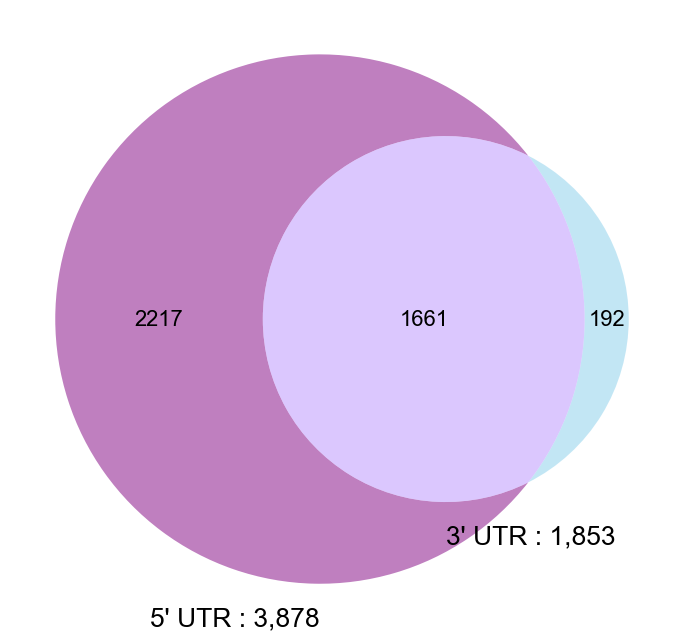

In [42]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import locale
# locale.setlocale(locale.LC_ALL, '') 
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 22})
venn2([
    set(test.loc[(test['5_prime_modif'] > 0)].Gene.unique().tolist()), 
    set(test.loc[(test['3_prime_modif'] > 0)].Gene.unique().tolist()),
], 
    set_labels=["5' UTR : {:,}".format(test.loc[(test['5_prime_modif'] > 0)].Gene.nunique()), "3' UTR : {:,}".format(test.loc[(test['3_prime_modif'] > 0)].Gene.nunique())], 
    set_colors=['purple', 'skyblue'], alpha=0.5)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


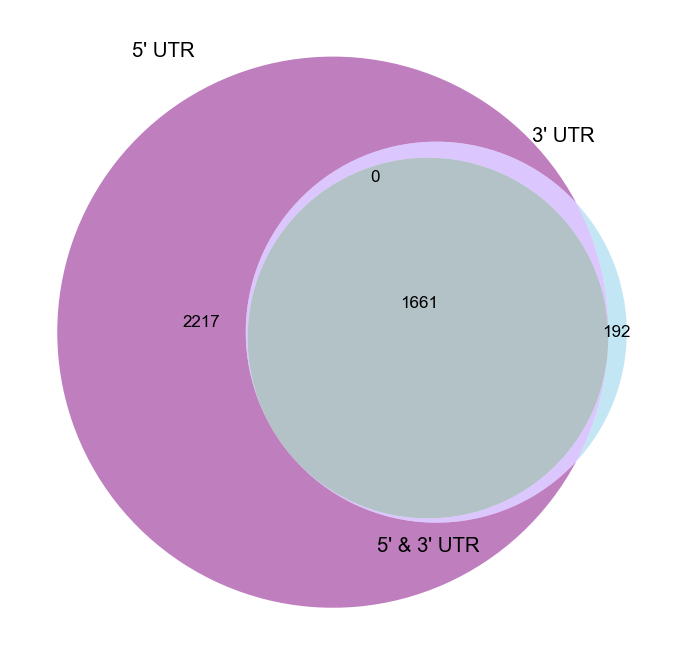

In [33]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.rcParams.update({"font.size" : 17})
venn3([
    set(test.loc[(test['5_prime_modif'] > 0)].Gene.unique().tolist()), 
    set(test.loc[(test['3_prime_modif'] > 0)].Gene.unique().tolist()),
    set(test.loc[(test['5_prime_modif'] > 0) & (test['3_prime_modif'] > 0)].Gene.tolist())
], 
    set_labels=["5' UTR", "3' UTR", "5' & 3' UTR"], 
    set_colors=['purple', 'skyblue', 'green'], alpha=0.5)



In [ ]:
merge_with_strand

In [ ]:
merge_with_strand.loc[merge_with_strand['Gene'] == 'A2M']

In [ ]:
biomart_raw.loc[biomart_raw['Gene name'] == 'A1CF']

In [ ]:
test.loc['Total'] = test.sum(axis=0)
test

In [ ]:
test = test.drop('Total')


In [ ]:
pd.concat([
    pd.DataFrame(test.loc[test['5_prime_modif'] != 0, '5_prime_modif'].describe()),
    pd.DataFrame(test.loc[test['3_prime_modif'] != 0, '3_prime_modif'].describe())
], axis=1
)

In [ ]:
test.loc[test['3_prime_modif'] != 0, '3_prime_modif'].describe()

In [ ]:
collections.Counter(test.loc['A1CF'].values.tolist()[0])

In [ ]:
def return_common_nb(r):
    if r['mRNA_nb'] > 1:
        print(r['Gene'], len(set(r['Exon_list_nb'])), len(r['Exon_list_nb']), r['Exon_list'], [e for e in r['Exon_list']])




In [ ]:
def return_common_nb(r):
    if r['mRNA_nb'] > 0:
        print(r['Gene'], len(set(r['Exon_list_nb'])), len(r['Exon_list_nb']), r['Exon_list'])
        if len(set(r['Exon_list_nb'])) < len(r['Exon_list_nb']):
            counter = dict(collections.Counter(r['Exon_list_nb']))
            print(counter)
            for mrna, count in counter.items():
                if count > 1:
                    print(mrna, counter[mrna])
#                     index_positions = [i for i, e in enumerate(r['Exon_list_nb']) if e == mrna]
#                     print(index_positions)
#                     intersect_exons_list = [set(r['Exon_list'][i]) for i in index_positions]
#                     print(len(set.intersection(*intersect_exons_list)), r['Exon_list_nb'][index_positions[0]])
#                     if len(set.intersection(*intersect_exons_list)) == r['Exon_list_nb'][index_positions[0]]:
#                         print(len(set.intersection(*intersect_exons_list)), r['Exon_list_nb'][index_positions[0]])
                

# concat_exons_gene_level['Intersection'] = concat_exons_gene_level['Exon_list'].apply(lambda r: set.intersection(*[set(e) for e in r]))
# concat_exons_gene_level['mRNA_nb'] = concat_exons_gene_level['mRNA'].apply(len)
# concat_exons_gene_level['Exon_list_nb'] = concat_exons_gene_level['Exon_list'].apply(lambda r: [len(e) for e in r])
# concat_exons_gene_level['Exon_list_set'] = concat_exons_gene_level['Exon_list_nb'].apply(lambda r: len(set(r)))
# concat_exons_gene_level['Check_at_least_two'] = concat_exons_gene_level.apply(lambda r: True if len(set(r['Exon_list_nb'])) < r['mRNA_nb'] else False, axis=1)
# concat_exons_gene_level['Check_common_nb'] = concat_exons_gene_level.apply(lambda r: True if len(set(r['Exon_list_nb'])) < r['mRNA_nb'] else False, axis=1)
concat_exons_gene_level.head().apply(lambda r: return_common_nb(r), axis=1)
# concat_exons_gene_level



In [ ]:
print(len(set(concat_exons_gene_level.loc[concat_exons_gene_level['Gene'] == 'A2M', 'Exon_list'].values.tolist()[0][0]).intersection(set(concat_exons_gene_level.loc[concat_exons_gene_level['Gene'] == 'A2M', 'Exon_list'].values.tolist()[0][1]))))
print(len(concat_exons_gene_level.loc[concat_exons_gene_level['Gene'] == 'A2M', 'Exon_list'].values.tolist()[0][0]))
# pprint(concat_exons_gene_level.loc[concat_exons_gene_level['Gene'] == 'A2M'].values.tolist())

In [ ]:
concat_exons_gene_level.loc[(concat_exons_gene_level['mRNA_nb'] > 1)].explode('mRNA').mRNA.nunique()

In [ ]:
concat_exons_gene_level.loc[(concat_exons_gene_level['mRNA_nb'] > 1)]

In [ ]:
concat_exons_gene_level.loc[(concat_exons_gene_level['mRNA_nb'] > 1) & (concat_exons_gene_level['Check_at_least_two'] == True)]

In [ ]:
concat_exons_gene_level.loc[(concat_exons_gene_level['mRNA_nb'] > 1) & (concat_exons_gene_level['Exon_list_set'] == 1)]

In [ ]:
concat_exons_gene_level = concat_exons_gene_level.reset_index()
concat_exons_gene_level.loc[(concat_exons_gene_level['mRNA_nb'] > 1) & (concat_exons_gene_level['Exon_list_set'] == 1) & (concat_exons_gene_level.Gene.isin(exotic.symbol.unique().tolist()))]


In [ ]:
refseq_corrected

In [ ]:
exotic.symbol.unique().tolist()

In [ ]:
concat_exons_gene_level.loc['A1BG'].to_dict()

In [ ]:
df.loc[df['Gene'] == 'AADACL2']

In [ ]:
from tqdm import tqdm
l = list()
for j, index in tqdm(enumerate(list(refseq_df_pc_genes.index))):
#     if j == 10:
#         break

    if j < len(list(refseq_df_pc_genes.index)) - 1 :
        start_index, stop_index = index, list(refseq_df_pc_genes.index)[j+1]

        current_gene = [e.replace('Name=', '') for e in refseq_df_pc_genes.loc[start_index]['Attributes'].split(';') if 'Name' in e][0]
        for cds in list(refseq_df_cds.index):
            if cds > start_index and cds < stop_index:

                current_gene_cds = [e.replace('gene=', '') for e in refseq_df_cds.loc[cds]['Attributes'].split(';') if 'gene' in e][0]
                parent_mrna = [e.replace('Parent=rna-', '') for e in refseq_df_cds.loc[cds]['Attributes'].split(';') if 'Parent' in e][0].split('.')[0]
                mrna_index = refseq_df_mrna.loc[refseq_df_mrna['Attributes'].str.contains(parent_mrna)].index[0]
                
                

#                 print(j, start_index, stop_index, cds, current_gene, current_gene_cds)

                if current_gene == current_gene_cds:
                    l.append(
                        {
                            'Gene' : current_gene,
                            'Gene_start' : refseq_df_pc_genes.loc[start_index]['Start'],
                            'Gene_stop' : refseq_df_pc_genes.loc[start_index]['End'],
                            'Exon_start' : refseq_df_cds.loc[cds]['Start'],
                            'Exon_stop' : refseq_df_cds.loc[cds]['End'],
                            'mRNA' : parent_mrna,
                            'mRNA_start' : refseq_df_mrna.loc[mrna_index]['Start'],
                            'mRNA_stop' : refseq_df_mrna.loc[mrna_index]['End'],
                        }
                    )
        
            
pd.options.display.max_rows =200
df = pd.DataFrame(l).sort_values(by=['Gene', 'Exon_start', 'Exon_stop']).drop_duplicates()
df['Length'] = df['Exon_stop'] - df['Exon_start']
df = df.sort_values(by=['Gene', 'Exon_start', 'Exon_stop', 'Length'], ascending=[True, True, True, False])
df = df.drop_duplicates(subset=['Gene', 'Exon_start'], keep='last').drop_duplicates(subset=['Gene', 'Exon_stop'], keep='first')

df


In [ ]:

output_json = dict()

for ig, gene in tqdm(enumerate(df.Gene.unique())):
    if ig == 10:
        break

    output_json[gene] = dict()

    tmp_gene_df = df.loc[df['Gene'] == gene]
    for chrom in chroms:
        if chrom[0] <= tmp_gene_df.index[0] < chrom[1]:
            
            output_json[gene]['CHROM'] = [c.replace('chromosome=', '') for c in refseq_df_chroms.loc[chrom[0]]['Attributes'].split(';') if 'chromosome=' in c][0]
# tmp_gene_df
    
    tmp_gene_df = tmp_gene_df.reset_index(drop=True)
    output_json[gene]['Gene_start_end'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
    for j, row in tmp_gene_df.iterrows():
        if 'Exon_list' not in output_json[gene]:
            output_json[gene]['Exon_list'] = list()
        if j == 0:
            output_json[gene]['5_prime_UTR'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(row.Exon_start - 1)
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
            if j == (tmp_gene_df.shape[0] - 1):
                output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
        elif j > 0 and j < (tmp_gene_df.shape[0] - 1):
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
        elif j == (tmp_gene_df.shape[0] - 1):
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
            output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
            
for gene in output_json:
    
    output_json[gene]['Exons_length'] = [int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Exon_list']]
    output_json[gene]['Intron_list'] = list()
    output_json[gene]['Exon_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Exon_list']])
    output_json[gene]['Bin_size_exon'] = round(output_json[gene]['Exon_size_total'] / 20)
    for j, exon in enumerate(output_json[gene]['Exon_list']):
        if j < len(output_json[gene]['Exon_list'])-1:
            intron_start = int(output_json[gene]['Exon_list'][j].split('_')[1]) + 1
            intron_end = int(output_json[gene]['Exon_list'][j+1].split('_')[0]) - 1
            output_json[gene]['Intron_list'].append('{}_{}'.format(str(intron_start), str(intron_end)))
    output_json[gene]['Intron_length'] = [int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Intron_list']]
    output_json[gene]['Intron_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Intron_list']])
    output_json[gene]['Bin_size_intron'] = round(output_json[gene]['Intron_size_total'] / 20)
    output_json[gene]['Gene_body_size'] = int(output_json[gene]['Gene_start_end'].split('_')[1]) - int(output_json[gene]['Gene_start_end'].split('_')[0])
    output_json[gene]['Bin_size_GB'] = round(output_json[gene]['Gene_body_size'] / 20)
    
    init_gene_body_bin = int(output_json[gene]['Gene_start_end'].split('_')[0])
    output_json[gene]['Bin_size_UpDown'] = round(5000 / 20)
    output_json[gene]['5_prime_UTR_size'] = int(output_json[gene]['5_prime_UTR'].split('_')[1]) - int(output_json[gene]['5_prime_UTR'].split('_')[0])
    output_json[gene]['3_prime_UTR_size'] = int(output_json[gene]['3_prime_UTR'].split('_')[1]) - int(output_json[gene]['3_prime_UTR'].split('_')[0])

    output_json[gene]['Bin_size_5_prime_UTR'] = round(int(output_json[gene]['5_prime_UTR_size']) / 20)
    output_json[gene]['Bin_size_3_prime_UTR'] = round(int(output_json[gene]['3_prime_UTR_size']) / 20)
            
refseq_df_transformed = pd.DataFrame.from_dict(output_json).T
refseq_df_transformed

In [ ]:
l = list()
for j, index in tqdm(enumerate(list(refseq_df_pc_genes.index))):
#     if j == 10:
#         break

    if j < len(list(refseq_df_pc_genes.index)) - 1 :
        start_index, stop_index = index, list(refseq_df_pc_genes.index)[j+1]

        current_gene = [e.replace('Name=', '') for e in refseq_df_pc_genes.loc[start_index]['Attributes'].split(';') if 'Name' in e][0]
        for cds in list(refseq_df_cds.index):
            if cds > start_index and cds < stop_index:

                current_gene_cds = [e.replace('gene=', '') for e in refseq_df_cds.loc[cds]['Attributes'].split(';') if 'gene' in e][0]

#                 print(j, start_index, stop_index, cds, current_gene, current_gene_cds)

                if current_gene == current_gene_cds:
                    l.append(
                        {
                            'Gene' : current_gene,
                            'Gene_start' : refseq_df_pc_genes.loc[start_index]['Start'],
                            'Gene_stop' : refseq_df_pc_genes.loc[start_index]['End'],
                            'Exon_start' : refseq_df_cds.loc[cds]['Start'],
                            'Exon_stop' : refseq_df_cds.loc[cds]['End'],
                        }
                    )
        
            
pd.options.display.max_rows =200
df = pd.DataFrame(l).sort_values(by=['Gene', 'Exon_start', 'Exon_stop']).drop_duplicates()
df['Length'] = df['Exon_stop'] - df['Exon_start']
df = df.sort_values(by=['Gene', 'Exon_start', 'Exon_stop', 'Length'], ascending=[True, True, True, False])
df = df.drop_duplicates(subset=['Gene', 'Exon_start'], keep='last').drop_duplicates(subset=['Gene', 'Exon_stop'], keep='first')

df

output_json = dict()

for ig, gene in tqdm(enumerate(df.Gene.unique())):
    if ig == 10:
        break

    output_json[gene] = dict()

    tmp_gene_df = df.loc[df['Gene'] == gene]
    for chrom in chroms:
        if chrom[0] <= tmp_gene_df.index[0] < chrom[1]:
            
            output_json[gene]['CHROM'] = [c.replace('chromosome=', '') for c in refseq_df_chroms.loc[chrom[0]]['Attributes'].split(';') if 'chromosome=' in c][0]
# tmp_gene_df
    
    tmp_gene_df = tmp_gene_df.reset_index(drop=True)
    output_json[gene]['Gene_start_end'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
    for j, row in tmp_gene_df.iterrows():
        if 'Exon_list' not in output_json[gene]:
            output_json[gene]['Exon_list'] = list()
        if j == 0:
            output_json[gene]['5_prime_UTR'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(row.Exon_start - 1)
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
            if j == (tmp_gene_df.shape[0] - 1):
                output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
        elif j > 0 and j < (tmp_gene_df.shape[0] - 1):
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
        elif j == (tmp_gene_df.shape[0] - 1):
            output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
            output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
            
for gene in output_json:
    
    output_json[gene]['Intron_list'] = list()
    output_json[gene]['Exon_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Exon_list']])
    output_json[gene]['Bin_size_exon'] = round(output_json[gene]['Exon_size_total'] / 20)
    for j, exon in enumerate(output_json[gene]['Exon_list']):
        if j < len(output_json[gene]['Exon_list'])-1:
            intron_start = int(output_json[gene]['Exon_list'][j].split('_')[1]) + 1
            intron_end = int(output_json[gene]['Exon_list'][j+1].split('_')[0]) - 1
            output_json[gene]['Intron_list'].append('{}_{}'.format(str(intron_start), str(intron_end)))
    output_json[gene]['Intron_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Intron_list']])
    output_json[gene]['Bin_size_intron'] = round(output_json[gene]['Intron_size_total'] / 20)
    output_json[gene]['Gene_body_size'] = int(output_json[gene]['Gene_start_end'].split('_')[1]) - int(output_json[gene]['Gene_start_end'].split('_')[0])
    output_json[gene]['Bin_size_GB'] = round(output_json[gene]['Gene_body_size'] / 20)
    
    init_gene_body_bin = int(output_json[gene]['Gene_start_end'].split('_')[0])
    output_json[gene]['Bin_size_UpDown'] = round(5000 / 20)
    output_json[gene]['5_prime_UTR_size'] = int(output_json[gene]['5_prime_UTR'].split('_')[1]) - int(output_json[gene]['5_prime_UTR'].split('_')[0])
    output_json[gene]['3_prime_UTR_size'] = int(output_json[gene]['3_prime_UTR'].split('_')[1]) - int(output_json[gene]['3_prime_UTR'].split('_')[0])

    output_json[gene]['Bin_size_5_prime_UTR'] = round(int(output_json[gene]['5_prime_UTR_size']) / 20)
    output_json[gene]['Bin_size_3_prime_UTR'] = round(int(output_json[gene]['3_prime_UTR_size']) / 20)
    
    output_json[gene]['Gene_body_bins'] = [round((b* output_json[gene]['Bin_size_GB']) + init_gene_body_bin) for b in range(20)]
    output_json[gene]['Gene_body_bins'] = [(e, output_json[gene]['Gene_body_bins'][i+1]) for i, e in enumerate(output_json[gene]['Gene_body_bins']) if i < len(output_json[gene]['Gene_body_bins'])-1]

    output_json[gene]['Upstream_bins'] = sorted([int(output_json[gene]['Gene_start_end'].split('_')[0]) - 1  - round((b* output_json[gene]['Bin_size_UpDown'])) for b in range(20)])
    output_json[gene]['Upstream_bins'] = [(e, output_json[gene]['Upstream_bins'][i+1]) for i, e in enumerate(output_json[gene]['Upstream_bins']) if i < len(output_json[gene]['Upstream_bins'])-1]

    output_json[gene]['Downstream_bins'] = [int(output_json[gene]['Gene_start_end'].split('_')[1]) + 1 + round((b* output_json[gene]['Bin_size_UpDown'])) for b in range(20)]
    output_json[gene]['Downstream_bins'] = [(e, output_json[gene]['Downstream_bins'][i+1]) for i, e in enumerate(output_json[gene]['Downstream_bins']) if i < len(output_json[gene]['Downstream_bins'])-1]


    output_json[gene]['Exon_bins'] = list()
    tmp_bins_list = [sub_pos for exon in output_json[gene]['Exon_list'] for sub_pos in range(int(exon.split('_')[0]), int(exon.split('_')[1]) + 1) ]
    output_json[gene]['Exon_bins'] = [pos for i, pos in enumerate(tmp_bins_list) if (i+1) % output_json[gene]['Bin_size_exon'] == 0]
    output_json[gene]['Exon_bins'] = [output_json[gene]['Exon_list'][0].split('_')[0]] + output_json[gene]['Exon_bins']
    output_json[gene]['Exon_bins'] = [(e, output_json[gene]['Exon_bins'][i+1]) for i, e in enumerate(output_json[gene]['Exon_bins']) if i < len(output_json[gene]['Exon_bins'])-1]
    
    current_size = 0
    previous_size = 0
    exon_bin_counter = 0
    
    for j, exon in enumerate(output_json[gene]['Exon_list']):
                
        if j < len(output_json[gene]['Exon_list'])-1:
            intron_start = int(output_json[gene]['Exon_list'][j].split('_')[1]) + 1
            intron_end = int(output_json[gene]['Exon_list'][j+1].split('_')[0]) - 1
            output_json[gene]['Intron_list'].append('{}_{}'.format(str(intron_start), str(intron_end)))
    
    
    
    output_json[gene]['Intron_bins'] = list()
    if output_json[gene]['Intron_list']:
        tmp_bins_list = [sub_pos for intron in output_json[gene]['Intron_list'] for sub_pos in range(int(intron.split('_')[0]), int(intron.split('_')[1]) + 1) ]
        output_json[gene]['Intron_bins'] = [pos for i, pos in enumerate(tmp_bins_list) if (i+1) % output_json[gene]['Bin_size_intron'] == 0]
        output_json[gene]['Intron_bins'] = [output_json[gene]['Intron_list'][0].split('_')[0]] + output_json[gene]['Intron_bins']
        output_json[gene]['Intron_bins'] = [(e, output_json[gene]['Intron_bins'][i+1]) for i, e in enumerate(output_json[gene]['Intron_bins']) if i < len(output_json[gene]['Intron_bins'])-1]
    
    
    output_json[gene]['BED_boundaries_for_hail_10kbp_added'] = "chr" +  str(output_json[gene]['CHROM']) + ':' + str((int(output_json[gene]['Gene_start_end'].split('_')[0]) - 5000)) + '-' + str((int(output_json[gene]['Gene_start_end'].split('_')[1]) + 5000))

                
                
            

In [ ]:
def test(genes, l):

    output_json = dict()
    bins_position = list()
    l = list()

    for ig, gene in enumerate(genes):
#         print(gene)
    #     if ig % 10 == 0:
    #         tmp_df = pd.DataFrame.from_dict(output_json).T
    #         print(tmp_df)
    #         l.append(tmp_df)
    #         output_json = dict()
    #         bins_position = list()

        output_json[gene] = dict()

        tmp_gene_df = df.loc[df['Gene'] == gene]
        for chrom in chroms:
            if chrom[0] <= tmp_gene_df.index[0] < chrom[1]:

                output_json[gene]['CHROM'] = [c.replace('chromosome=', '') for c in refseq_df_chroms.loc[chrom[0]]['Attributes'].split(';') if 'chromosome=' in c][0]
    # tmp_gene_df

        tmp_gene_df = tmp_gene_df.reset_index(drop=True)
        output_json[gene]['Gene_start_end'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
        for j, row in tmp_gene_df.iterrows():
            if 'Exon_list' not in output_json[gene]:
                output_json[gene]['Exon_list'] = list()
            if j == 0:
                output_json[gene]['5_prime_UTR'] = str(tmp_gene_df.Gene_start.unique()[0]) + '_' + str(row.Exon_start - 1)
                output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
                if j == (tmp_gene_df.shape[0] - 1):
                    output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
            elif j > 0 and j < (tmp_gene_df.shape[0] - 1):
                output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
            elif j == (tmp_gene_df.shape[0] - 1):
                output_json[gene]['Exon_list'].append(str(row.Exon_start) + '_' + str(row.Exon_stop))
                output_json[gene]['3_prime_UTR'] = str(row.Exon_stop + 1) + '_' + str(tmp_gene_df.Gene_stop.unique()[0])
    for gene in output_json:
        output_json[gene]['Intron_list'] = list()
        output_json[gene]['Exon_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Exon_list']])
        output_json[gene]['Bin_size_exon'] = round(output_json[gene]['Exon_size_total'] / 20)
        for j, exon in enumerate(output_json[gene]['Exon_list']):
            
            if j < len(output_json[gene]['Exon_list'])-1:
                intron_start = int(output_json[gene]['Exon_list'][j].split('_')[1]) + 1
                intron_end = int(output_json[gene]['Exon_list'][j+1].split('_')[0]) - 1
#                 print(j, output_json[gene]['Exon_list'][j].split('_')[1], intron_start, intron_end, output_json[gene]['Exon_list'][j+1].split('_')[0])
                
                output_json[gene]['Intron_list'].append('{}_{}'.format(str(intron_start), str(intron_end)))
        output_json[gene]['Intron_size_total'] = sum([int(e.split('_')[1]) - int(e.split('_')[0]) for e in output_json[gene]['Intron_list']])
        output_json[gene]['Bin_size_intron'] = round(output_json[gene]['Intron_size_total'] / 20)
        output_json[gene]['Gene_body_size'] = int(output_json[gene]['Gene_start_end'].split('_')[1]) - int(output_json[gene]['Gene_start_end'].split('_')[0])
        output_json[gene]['Bin_size_GB'] = round(output_json[gene]['Gene_body_size'] / 20)

        init_gene_body_bin = int(output_json[gene]['Gene_start_end'].split('_')[0])
        output_json[gene]['Bin_size_UpDown'] = round(5000 / 20)
        output_json[gene]['5_prime_UTR_size'] = int(output_json[gene]['5_prime_UTR'].split('_')[1]) - int(output_json[gene]['5_prime_UTR'].split('_')[0])
        output_json[gene]['3_prime_UTR_size'] = int(output_json[gene]['3_prime_UTR'].split('_')[1]) - int(output_json[gene]['3_prime_UTR'].split('_')[0])

        output_json[gene]['Bin_size_5_prime_UTR'] = round(int(output_json[gene]['5_prime_UTR_size']) / 20)
        output_json[gene]['Bin_size_3_prime_UTR'] = round(int(output_json[gene]['3_prime_UTR_size']) / 20)

        output_json[gene]['Gene_body_bins'] = [round((b* output_json[gene]['Bin_size_GB']) + init_gene_body_bin) for b in range(20)]
        output_json[gene]['Gene_body_bins'] = ["{}_{}".format(str(e), str(output_json[gene]['Gene_body_bins'][i+1])) for i, e in enumerate(output_json[gene]['Gene_body_bins']) if i < len(output_json[gene]['Gene_body_bins'])-1]

        output_json[gene]['Upstream_bins'] = sorted([int(output_json[gene]['Gene_start_end'].split('_')[0]) - 1  - round((b* output_json[gene]['Bin_size_UpDown'])) for b in range(20)])
        output_json[gene]['Upstream_bins'] = ["{}_{}".format(str(e), str(output_json[gene]['Upstream_bins'][i+1])) for i, e in enumerate(output_json[gene]['Upstream_bins']) if i < len(output_json[gene]['Upstream_bins'])-1]

        output_json[gene]['Downstream_bins'] = [int(output_json[gene]['Gene_start_end'].split('_')[1]) + 1 + round((b* output_json[gene]['Bin_size_UpDown'])) for b in range(20)]
        output_json[gene]['Downstream_bins'] = ["{}_{}".format(str(e), str(output_json[gene]['Downstream_bins'][i+1])) for i, e in enumerate(output_json[gene]['Downstream_bins']) if i < len(output_json[gene]['Downstream_bins'])-1]


        output_json[gene]['Exon_bins'] = list()
        tmp_bins_list = [sub_pos for exon in output_json[gene]['Exon_list'] for sub_pos in range(int(exon.split('_')[0]), int(exon.split('_')[1]) + 1) ]
        output_json[gene]['Exon_bins'] = [pos for i, pos in enumerate(tmp_bins_list) if (i+1) % output_json[gene]['Bin_size_exon'] == 0]
        output_json[gene]['Exon_bins'] = [output_json[gene]['Exon_list'][0].split('_')[0]] + output_json[gene]['Exon_bins']
        output_json[gene]['Exon_bins'] = ["{}_{}".format(str(e), str(output_json[gene]['Exon_bins'][i+1])) for i, e in enumerate(output_json[gene]['Exon_bins']) if i < len(output_json[gene]['Exon_bins'])-1]

        current_size = 0
        previous_size = 0
        exon_bin_counter = 0

        for j, exon in enumerate(output_json[gene]['Exon_list']):

            if j < len(output_json[gene]['Exon_list'])-1:
                intron_start = int(output_json[gene]['Exon_list'][j].split('_')[1]) + 1
                intron_end = int(output_json[gene]['Exon_list'][j+1].split('_')[0]) - 1
                output_json[gene]['Intron_list'].append('{}_{}'.format(str(intron_start), str(intron_end)))

        for elem in ['Gene_body_bins', 'Upstream_bins', 'Downstream_bins', 'Exon_bins']:
            bins_position.extend([{'CHR' :  'chr' +  output_json[gene]['CHROM'], 'Start' : e.split('_')[0], 'End' : e.split('_')[1], 'Region_type' : elem.replace('_bins', ''), 'Num' : i,  'Gene': gene} for i,e in zip(list(range(1,21)), output_json[gene][elem])])

        output_json[gene]['Intron_bins'] = list()
        if output_json[gene]['Intron_list']:
            tmp_bins_list = [sub_pos for intron in output_json[gene]['Intron_list'] for sub_pos in range(int(intron.split('_')[0]), int(intron.split('_')[1]) + 1) ]
#             print(len(tmp_bins_list))
#             output_json[gene]['Intron_bins'] = [pos for i, pos in enumerate(tmp_bins_list) if (i+1) % output_json[gene]['Bin_size_intron'] == 0]
#             output_json[gene]['Intron_bins'] = [output_json[gene]['Intron_list'][0].split('_')[0]] + output_json[gene]['Intron_bins']
#             output_json[gene]['Intron_bins'] = ["{}_{}".format(str(e), str(output_json[gene]['Intron_bins'][i+1])) for i, e in enumerate(output_json[gene]['Intron_bins']) if i < len(output_json[gene]['Intron_bins'])-1]
#             bins_position.extend([{'CHR' :  'chr' +  output_json[gene]['CHROM'],  'Start' : e.split('_')[0], 'End' : e.split('_')[1], 'Region_type' : elem.replace('_bins', ''), 'Num' : i, 'Gene' :  gene} for i,e in zip(list(range(1,21)), output_json[gene]['Intron_bins'])])
#     #         bins_position.extend([{'Num' : i, 'CHR' :  'chr' +  output_json[gene]['CHROM'], 'Region' : e, 'Region_type' : elem.replace('_bins', '')} for i,e in zip(list(range(1,21)), output_json[gene][elem])])

        output_json[gene]['BED_boundaries_for_hail_10kbp_added'] = "chr" +  str(output_json[gene]['CHROM']) + ':' + str((int(output_json[gene]['Gene_start_end'].split('_')[0]) - 5000)) + '-' + str((int(output_json[gene]['Gene_start_end'].split('_')[1]) + 5000))


#     refseq_df_transformed = pd.DataFrame.from_dict(output_json)
    tmp_dict = output_json[gene]
    tmp_dict['Gene'] = gene
    return tmp_dict
# refseq_df_transformed = pd.concat(l)
# refseq_df_transformed

tmp_list = list()
m = multiprocessing.Manager()
final_list_concat= m.list()
test_list = df.Gene.unique().tolist()[:200]

# tmp_list.append(test(test_list[:1], []))
# pd.DataFrame(tmp_list)

chunks = [test_list[x:x+1] for x in range(0, len(test_list), 1)]
# parmap.starmap(test, list(zip(chunks)), final_list_concat, pm_pbar=True)

for gene in tqdm(test_list):
    tmp_list.append(test([gene], tmp_list))


# for i, gene in enumerate):
#     tmp_list.append(gene)
#     if i % 10 == 0:
#         final_list_concat.append(test(tmp_list))
#         tmp_list = list()
        
tmp2 = pd.DataFrame(list(tmp_list))
tmp2
    

In [ ]:
tmp2

In [ ]:
refseq_df_transformed.to_parquet("/gstock/EXOTIC/data/GENOMICS/refseq_df_transformed.parquet")

In [ ]:
refseq_df_transformed.to_csv("/gstock/EXOTIC/data/GENOMICS/refseq_df_transformed.csv.gz", compression='gzip', sep='\t')

In [ ]:
bed = pd.DataFrame(bins_position)
bed['Start'] = bed['Start'].astype(int)
bed['End'] = bed['End'].astype(int)
bed = bed.loc[(bed['Start'] > 0 ) & (bed['End'] > 0 )]
bed.to_csv('/gstock/EXOTIC/data/GENOMICS/BED_test_h.txt', sep='\t', index=False)
bed

In [ ]:
refseq_df_transformed.to_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_precomputed.parquet')

In [ ]:
refseq_df_transformed  = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_precomputed.parquet')
refseq_df_transformed

In [24]:
biomart_raw = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_with_strand.txt.gz', compression='gzip', sep='\t')
# biomart_raw['Gene_start_end_ENS'] = biomart_raw['Gene start (bp)'].astype(str) + '_' + biomart_raw['Gene end (bp)'].astype(str)
biomart_raw

,Gene stable ID,Transcript stable ID,Strand,Gene name,Transcript type,Gene type,Gene % GC content,APPRIS annotation,Transcript support level (TSL),Transcript length (including UTRs and CDS),Transcription start site (TSS),Transcript end (bp),Transcript start (bp),Gene end (bp),Gene start (bp),Transcript count,RefSeq mRNA ID,HGNC ID
0,ENSG00000210049,ENST00000387314,1,MT-TF,Mt_tRNA,Mt_tRNA,40.85,NaN,tslNA,71,577,647,577,647,577,1,NaN,HGNC:7481
1,ENSG00000211459,ENST00000389680,1,MT-RNR1,Mt_rRNA,Mt_rRNA,45.49,NaN,tslNA,954,648,1601,648,1601,648,1,NaN,HGNC:7470
2,ENSG00000210077,ENST00000387342,1,MT-TV,Mt_tRNA,Mt_tRNA,42.03,NaN,tslNA,69,1602,1670,1602,1670,1602,1,NaN,HGNC:7500
3,ENSG00000210082,ENST00000387347,1,MT-RNR2,Mt_rRNA,Mt_rRNA,42.81,NaN,tslNA,1559,1671,3229,1671,3229,1671,1,NaN,HGNC:7471
4,ENSG00000209082,ENST00000386347,1,MT-TL1,Mt_tRNA,Mt_tRNA,38.67,NaN,tslNA,75,3230,3304,3230,3304,3230,1,NaN,HGNC:7490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276111,ENSG00000185220,ENST00000355360,1,PGBD2,protein_coding,protein_coding,46.25,NaN,tsl1,2879,248906196,248919946,248906196,248919946,248906196,3,NM_001017434,HGNC:19399
276112,ENSG00000185220,ENST00000329291,1,PGBD2,protein_coding,protein_coding,46.25,principal1,tsl1 (assigned to previous version 5),2717,248906235,248919146,248906235,248919946,248906196,3,NM_170725,HGNC:19399
276113,ENSG00000185220,ENST00000462488,1,PGBD2,processed_transcript,protein_coding,46.25,NaN,tsl5,282,248906372,248917401,248906372,248919946,248906196,3,NaN,HGNC:19399
276114,ENSG00000200495,ENST00000363625,-1,RNU6-1205P,snRNA,snRNA,40.57,NaN,tslNA,106,248912795,248912795,248912690,248912795,248912690,1,NaN,HGNC:48168


In [ ]:
biomart_raw[['RefSeq mRNA ID', 'Strand']].dropna()

In [ ]:
merge_biomart_refseq_38 = pd.merge(biomart_raw.loc[biomart_raw['Gene stable ID'].isin(exotic_genes_not_sqtl), ['Gene stable ID', 'Gene name']].drop_duplicates().sort_values(by='Gene name'), refseq_df_transformed.reset_index(), left_on='Gene name', right_on='index')
merge_biomart_refseq_38['Gene_start'] = merge_biomart_refseq_38.Gene_start_end.apply(lambda r: r.split('_')[0])
merge_biomart_refseq_38['Gene_start'] = merge_biomart_refseq_38['Gene_start'].astype(int)
merge_biomart_refseq_38['Gene_end'] = merge_biomart_refseq_38.Gene_start_end.apply(lambda r: r.split('_')[1])
merge_biomart_refseq_38['Gene_end'] = merge_biomart_refseq_38['Gene_end'].astype(int)
merge_biomart_refseq_38

In [ ]:
merge_biomart_refseq_38

# LiftOver

In [ ]:
from liftover import ChainFile
converter = ChainFile("/gstock/biolo_datasets/variation/benchmark/Databases/CrossMap/GRCh38_to_GRCh37.chain.gz", "GRCh38", "GRCh37")

def apply_liftover(r, name):
#     print(r)
    try:
        output = converter[r["CHROM"]][int(r[name])]
        # print(output)
        converted_pos = output[0][1]
    except KeyError:
        converted_pos = np.nan
    except IndexError:
        converted_pos = np.nan
    return converted_pos

# EXOTIC

In [ ]:
exotic = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_min_max_processed.parquet')
exotic[['Exon_start', 'Exon_end']] = exotic['Exon'].str.split('-', expand=True)

# COMPUTE BINS EXOTIC-MAX
bins = np.arange(0.5,1.05,0.05)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]

# COMPUTE BINS COLUMNS
exotic["EXOTIC_bins_max"] = pd.cut(exotic["EXOTIC_max"], bins=bins, labels=labels_ratio, include_lowest=True)

# COMPUTE BINS EXOTIC-MIN
bins = np.arange(0,0.55,0.05)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]

# COMPUTE BINS COLUMNS
exotic["EXOTIC_bins_min"] = pd.cut(exotic["EXOTIC_min"], bins=bins, labels=labels_ratio, include_lowest=True)
exotic





In [ ]:
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')
biomart.head()

In [ ]:
merge_gene_chr = pd.merge(biomart[['Chromosome/scaffold name', 'Gene name']].drop_duplicates().rename({'Gene name' : 'symbol'}, axis=1), exotic[['symbol']].drop_duplicates(), on='symbol')
merge_gene_chr['Chromosome/scaffold name'] = merge_gene_chr['Chromosome/scaffold name'].astype(str)
merge_gene_chr =  merge_gene_chr.loc[~merge_gene_chr['Chromosome/scaffold name'].str.contains('CHR')]
merge_gene_chr.columns = ['CHROM', 'symbol']
exotic = pd.merge(exotic, merge_gene_chr, on='symbol')
exotic.head()


In [ ]:
tqdm.pandas()
exotic['Exon_start_38'] = exotic[['CHROM', 'Exon_start']].progress_apply(lambda r: apply_liftover(r, 'Exon_start'), axis=1)
exotic['Exon_end_38'] = exotic[['CHROM', 'Exon_end']].progress_apply(lambda r: apply_liftover(r, 'Exon_end'), axis=1)


In [ ]:
exotic

In [ ]:
exotic[['CHROM', 'Exon_start', 'Exon_end', 'MAP']].sort_values(by=['CHROM', 'Exon_start']).to_csv('/biolo/ngs/remap/EXOTIC.bed', header=False,sep='\t', index=False)


In [ ]:
exotic[['CHROM', 'Exon_start', 'Exon_end', 'MAP']].sort_values(by=['CHROM', 'Exon_start']).to_csv('/biolo/ngs/remap/EXOTIC.bed', header=False,sep='\t', index=False)
import subprocess
subprocess.call("/usr/local/bin/perl remap_api.pl --mode asm-asm --from GCF_000001405.25 --dest GCF_000001405.26 --annotation /biolo/ngs/remap/EXOTIC.bed --annot_out /biolo/ngs/remap/EXOTIC_remap.bed --report_out report --in_format bed --out_format bed", shell=True)
exotic_remap_map = pd.read_csv('/biolo/ngs/remap/EXOTIC_remap.bed', sep='\t', names=['CHROM_38', 'Exon_start_38', 'Exon_end_38', 'MAP'])
exotic_remap_map = exotic_remap_map.loc[~exotic_remap_map['CHROM_38'].str.contains('HSCHR')]
exotic_remap_map

In [ ]:
exotic[['CHROM', 'Exon_start', 'Exon_end', 'MAP']]

In [ ]:
refseq_corrected

In [ ]:
refseq_corrected = pd.read_csv('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx.csv.gz', compression="gzip", sep='\t')
refseq_corrected['MAP'] = refseq_corrected.Gene + '_' + refseq_corrected.ranges.astype(str)
tmp = pd.merge(
    refseq_corrected[['MAP']],
    refseq_37,
    on='MAP'
)
sns.boxenplot(data=tmp, x='Sharing_status', y='Length')
plt.ylim(0,500)


In [ ]:
refseq_37.loc[refseq_37['Gene'] == 'ZNF701']

In [ ]:
refseq_37 = pd.read_csv('/gstock/EXOTIC/data/GENOMICS/RefSeq_processed.csv.gz', compression="gzip", sep='\t')
refseq_37['MAP'] = refseq_37.Gene + '_' + refseq_37.Start.astype(str) + '-' + refseq_37.End.astype(str)
refseq_37 = refseq_37.drop_duplicates(subset='MAP')
refseq_37.Sharing_status.value_counts()

In [ ]:
pd.merge(
    exotic_remap_map.loc[~exotic_remap_map['MAP'].isin(pd.merge(refseq_df_transformed[['symbol', 'CHROM', 'Exon_list']].explode('Exon_list').rename({'Exon_list' : 'Exon_38'},axis=1), exotic_remap_map, on='Exon_38').MAP.values)],
    refseq_37,
    on='MAP'
).CDS_representation.value_counts()

In [ ]:
pd.merge(
    exotic[["MAP"]],
    refseq_37,
    on='MAP'
).CDS_representation.value_counts()

In [ ]:
exotic_remap_map = pd.read_csv('/biolo/ngs/remap/EXOTIC_remap.bed', sep='\t', names=['CHROM_38', 'Exon_start_38', 'Exon_end_38', 'MAP'])
exotic_remap_map = exotic_remap_map.loc[~exotic_remap_map['CHROM_38'].str.contains('HSCHR')]
exotic_remap_map['Exon_38'] = exotic_remap_map['Exon_start_38'].astype(str) + '_' + exotic_remap_map['Exon_end_38'].astype(str)
exotic_remap_map

In [ ]:
exotic_remap_map.loc[~exotic_remap_map['MAP'].isin(pd.merge(refseq_df_transformed[['symbol', 'CHROM', 'Exon_list']].explode('Exon_list').rename({'Exon_list' : 'Exon_38'},axis=1), exotic_remap_map, on='Exon_38').MAP.values)]

In [ ]:
tmp

In [ ]:
tmp = pd.merge(exotic, exotic_remap_map, on='MAP')
tmp['EXOTIC_check_pext_min'] = tmp['EXOTIC_check_pext_min'].astype(str)
tmp['EXOTIC_check_pext_max'] = tmp['EXOTIC_check_pext_max'].astype(str)
tmp.to_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_38.parquet')

# DROPNA

In [ ]:
exotic['Exon_start_38'].isna().sum()

In [ ]:
exotic['Exon_end_38'].isna().sum()

In [ ]:
exotic['Exon_end_38'].isna().sum() / exotic_test.shape[0]


In [ ]:
t = pd.concat([exotic['Exon_start_38'].isna(), exotic['EXOTIC_bins_max']], axis=1).groupby('EXOTIC_bins_max')['Exon_start_38'].value_counts()
t = pd.DataFrame(t) 
t.columns = ['Count']
t = t.reset_index()
t = t.pivot(index='EXOTIC_bins_max', columns='Exon_start_38', values='Count')
t['Total'] = t[True] + t[False]
t['Diff%'] = 100 * (((t["Total"] - t[False]) / t["Total"]))
t


In [ ]:
t = pd.concat([exotic['Exon_start_38'].isna(), exotic['EXOTIC_bins_min']], axis=1).groupby('EXOTIC_bins_min')['Exon_start_38'].value_counts()
t = pd.DataFrame(t) 
t.columns = ['Count']
t = t.reset_index()
t = t.pivot(index='EXOTIC_bins_min', columns='Exon_start_38', values='Count')
t['Total'] = t[True] + t[False]
t['Diff%'] = 100 * (((t["Total"] - t[False]) / t["Total"]))
t


In [ ]:
refseq_df_transformed = refseq_df_transformed.reset_index().rename({'index' : 'symbol'}, axis=1)
refseq_df_transformed

In [ ]:
exotic

In [ ]:
exotic_wt_nas

In [ ]:
exotic_wt_nas = exotic.dropna(subset=['Exon_start_38', 'Exon_end_38'])
exotic_wt_nas['Exon_38'] = exotic_wt_nas['Exon_start_38'].astype(int).astype(str) + '_' + exotic_wt_nas['Exon_end_38'].astype(int).astype(str)
pd.merge(refseq_df_transformed[['symbol', 'CHROM', 'Exon_list']].explode('Exon_list'), exotic_wt_nas, left_on='Exon_list', right_on='Exon_38')

In [ ]:
refseq_df_transformed.loc[refseq_df_transformed['symbol'] == 'AACS']['Exon_list'].values

In [ ]:
tmp = refseq_df_transformed[['symbol', 'CHROM', 'Exon_list']].explode('Exon_list')
tmp[['Exon_start', 'Exon_end']] = tmp['Exon_list'].str.split('_', expand=True)
tmp['Exon_start_37'] = tmp[['CHROM', 'Exon_start']].progress_apply(lambda r: apply_liftover(r, 'Exon_start'), axis=1)
tmp['Exon_end_37'] = tmp[['CHROM', 'Exon_end']].progress_apply(lambda r: apply_liftover(r, 'Exon_end'), axis=1)
tmp = tmp.dropna()
tmp['Exon_start_37'] = tmp['Exon_start_37'].astype(int)
tmp['Exon_end_37'] = tmp['Exon_end_37'].astype(int)
tmp


In [ ]:
tmp = tmp.dropna()
tmp['Exon_start_37'] = tmp['Exon_start_37'].astype(int).astype(str)
tmp['Exon_end_37'] = tmp['Exon_end_37'].astype(int).astype(str)
tmp['Exon_37'] = tmp['Exon_start_37'].astype(int).astype(str) + '-' + tmp['Exon_end_37'].astype(int).astype(str)

tmp

In [ ]:
exotic

In [ ]:
pd.merge(exotic[['symbol', 'Exon_end']], tmp[['symbol', 'Exon_end_37']], left_on='Exon_end', right_on='Exon_end_37')